In [1]:
import pandas as pd
import numpy as np
import itertools
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import bottleneck as bn

In [2]:
def read_cococonet(file_location):
    import h5py
    net = h5py.File(file_location,'r')
    agg_dataset = net['agg'] 
    row_dataset = net['row']
    col_dataset = net['col']
    row_gene_list = []
    for gene in row_dataset:
        row_gene_list.append(gene.decode('UTF-8'))
    col_gene_list = []
    for gene in col_dataset: 
        col_gene_list.append(gene.decode('UTF-8'))
    net_df = pd.DataFrame(data = agg_dataset[:,:], index = row_gene_list, columns = col_gene_list)
    net.close()
    return net_df

In [3]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan

    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


In [4]:
def get_go_annotations_as_panda(species):
    import pandas as pd
    ## TAXA_ID to species_name 
    if type(species) == int:
        mapper = pd.read_csv('/home/passala/Gene_duplication_project/Generated_tables/Time_Savers/Species_name_resolver.csv')
        species = mapper['Common Name'].loc[mapper['Taxa ID'] == species].item()

    ## Get file_location 
    file_location = '/data/CoCoCoNet/gene2go/' + species + '_gene2go.csv'
    original_csv = pd.read_csv(file_location,sep = ' ')
    if len(original_csv) == 0:
        raise NameError('No Annotations for this Species :(')
    original_csv = original_csv.dropna()
    original_csv['Present'] = 1 
    matrixed_version = original_csv.pivot(index = 'NetworkIDs',columns = 'GO_term',values = 'Present')
    filled_matrixed_version = matrixed_version.fillna(value = 0)
    return filled_matrixed_version





In [5]:
def get_fc_sc_btw_two_species_with_gene_list(species_1,species_2,list_of_genes_in_species_1_as_panda):
    import pandas as pd
    import numpy as np
    #Convert Taxa to common names if NCBI taxa ID
    #Set up variable 
    fc_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Species_name_resolver.csv')

    if type(species_1) == int:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_1].item()
    if type(species_2) == int:
        species_2 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_2].item()

    #Convert scientific name to common names if given scientific
    if ' ' in species_1:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_1].item()
    if ' ' in species_2:
        species_2 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_2].item()

    #Get Scientific Name
    scientific_1 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_1].item()
    scientific_2 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_2].item()

    if species_1 == species_2:
        raise NameError("Species are the Same, submit different species")
    
    # Get Path for Orthologs
    path_to_orthologs_mapped_pd = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_fc_scores.csv',index_col = 0)
    path_to_orthologs = path_to_orthologs_mapped_pd.loc[scientific_1,scientific_2]

    ortholog_map = pd.read_csv(path_to_orthologs)
    file_name = path_to_orthologs.split('/')[-1]
    file_name = file_name.split('_')
    if file_name[0] == species_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'sp1_gene'})
        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(ortholog_map,on = 'sp1_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)
    if file_name[1] == species_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'sp2_gene'})
        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(ortholog_map,on = 'sp2_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)
    # return fc_sc_map,species_name
    return fc_sc_map

In [6]:
all_go_terms = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/go_terms.txt',sep = '\t')
all_go_terms[['grape','arabidopsis','mustard','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']] = np.nan
all_go_terms

Name  grape  \
GO:0000001                          mitochondrion inheritance    NaN   
GO:0000002                   mitochondrial genome maintenance    NaN   
GO:0000003                                       reproduction    NaN   
GO:0000006  high-affinity zinc transmembrane transporter a...    NaN   
GO:0000007  low-affinity zinc ion transmembrane transporte...    NaN   
...                                                       ...    ...   
GO:2001313  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...    NaN   
GO:2001314  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...    NaN   
GO:2001315  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...    NaN   
GO:2001316                       kojic acid metabolic process    NaN   
GO:2001317                    kojic acid biosynthetic process    NaN   

            arabidopsis  mustard  soybean  medicago  tomato  potato  rice  \
GO:0000001          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000002          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000003          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000006          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000007          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
...                 ...      ...      ...       ...     ...     ...   ...   
GO:2001313          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001314          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001315          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001316          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001317          NaN      NaN      NaN       NaN     NaN     NaN   NaN   

            brome  sorghum  maize  
GO:0000001    NaN      NaN    NaN  
GO:0000002    NaN      NaN    NaN  
GO:0000003    NaN      NaN    NaN  
GO:0000006    NaN      NaN    NaN  
GO:0000007    NaN      NaN    NaN  
...           ...      ...    ...  
GO:2001313    NaN      NaN    NaN  
GO:2001314    NaN      NaN    NaN  
GO:2001315    NaN      NaN    NaN  
GO:2001316    NaN      NaN    NaN  
GO:2001317    NaN      NaN    NaN  

[44272 rows x 12 columns]

In [7]:
dimension = pd.read_csv('/home/passala/Gene_duplication_project/Code/Penelope_maize_meristem_project/Minor_tables/dimension_dataframe.csv')

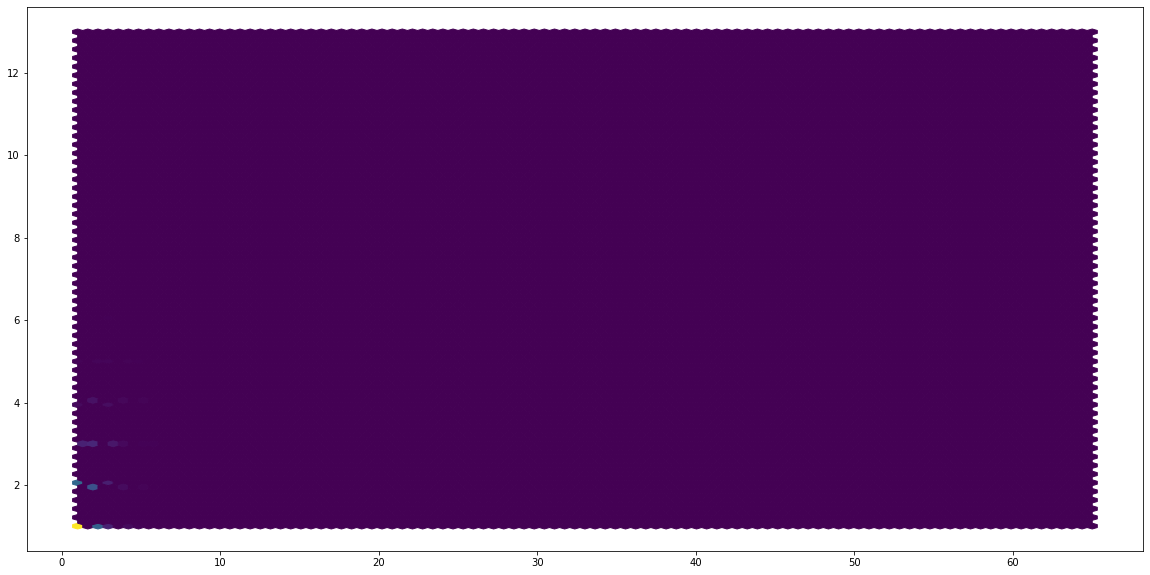

In [31]:
fig, ax = plt.subplots(figsize = (20,10))
plt.hexbin( x = dimension['Number of Arabidopsis Genes'],y = dimension['Number of Maize Genes'])
plt.show()

In [10]:
#coconet_plants = ['grape','arabidopsis','mustard','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']
coconet_plants = ['grape','arabidopsis','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']
plant_combinations = itertools.permutations(coconet_plants,2)
plant_combinations = list(map(list,plant_combinations))

In [11]:
all_go_terms = all_go_terms.drop(columns = ['mustard'])


In [12]:
# all_go_terms = all_go_terms.drop(columns = ['mustard','rice','brome','sorghum','maize'])
# all_go_terms

In [13]:
coconet_eudicots = ['grape','arabidopsis','soybean','medicago','tomato','potato']

In [14]:
# for species in coconet_eudicots:
#     print(species)
#     combos_that_start_with_species = []
#     for combo in plant_combinations:
#         if combo[0] == species:
#             combos_that_start_with_species.append(combo)
#     current_species_annotations = get_go_annotations_as_panda(species)
#     go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     for current_go_term in go_groups_with_counts.index.to_list():
#         current_go_term_list_of_fc_scores = []
#         genes_in_go_term = current_species_annotations.loc[current_species_annotations[current_go_term]==1].index
#         genes_in_go_term = pd.DataFrame(data =list(genes_in_go_term),columns = ['Genes'])
#         for current_combination in combos_that_start_with_species:
#             current_fc_map =get_fc_sc_btw_two_species_with_gene_list(current_combination[0],current_combination[1],genes_in_go_term)
#             mean_fc = current_fc_map.mean()[0]
#             current_go_term_list_of_fc_scores.append(mean_fc)
#         mean_across_species = statistics.mean(current_go_term_list_of_fc_scores)
#         all_go_terms.loc[current_go_term,species] = mean_across_species





In [15]:
# for species in coconet_plants:
#     print(species)
#     combos_that_start_with_species = []
#     for combo in plant_combinations:
#         if combo[0] == species:
#             combos_that_start_with_species.append(combo)
#     current_species_annotations = get_go_annotations_as_panda(species)
#     go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     for current_go_term in go_groups_with_counts.index.to_list():
#         current_go_term_list_of_fc_scores = []
#         genes_in_go_term = current_species_annotations.loc[current_species_annotations[current_go_term]==1].index
#         genes_in_go_term = pd.DataFrame(data =list(genes_in_go_term),columns = ['Genes'])
#         for current_combination in combos_that_start_with_species:
#             current_fc_map =get_fc_sc_btw_two_species_with_gene_list(current_combination[0],current_combination[1],genes_in_go_term)
#             mean_fc = current_fc_map.mean()[0]
#             current_go_term_list_of_fc_scores.append(mean_fc)
#         variance_across_species = statistics.variance(current_go_term_list_of_fc_scores)
#         all_go_terms.loc[current_go_term,species] = variance_across_species



In [16]:
# variance_all_eudicots = all_go_terms
# variance_all_eudicots.to_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/eudicot_variance.csv')

In [17]:
variance_all_eudicots = pd.read_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/eudicot_variance.csv',index_col = 0)

In [18]:
#all_terms_eudicots = all_go_terms
#all_terms_eudicots.to_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/all_eudicot_terms_no_mustard.csv')
all_terms_no_mustard = pd.read_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/all_eudicot_terms_no_mustard.csv',index_col= 0)

In [19]:
all_go_terms = pd.read_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/go_terms_and_avg_fc_score_in_each_species.csv',index_col= 0)

In [20]:
#all_go_terms = all_go_terms.drop(columns = 'mustard')

In [21]:
number_of_groups_for_each_go_term = all_go_terms.drop(columns = 'Name').count(axis = 1)
average_functional_conservation_for_each_term = all_go_terms.mean(axis = 1)

/tmp/ipykernel_2420154/149521952.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_functional_conservation_for_each_term = all_go_terms.mean(axis = 1)


In [22]:
all_group_go_terms = all_go_terms.loc[number_of_groups_for_each_go_term>9]
all_group_go_terms

Name     grape  \
GO:0000003                                       reproduction  0.720469   
GO:0000041                     transition metal ion transport  0.676016   
GO:0000079  regulation of cyclin-dependent protein serine/...  0.748729   
GO:0000096                sulfur amino acid metabolic process  0.691024   
GO:0000097             sulfur amino acid biosynthetic process  0.683022   
...                                                       ...       ...   
GO:0006732                                                NaN  0.698273   
GO:0051187                                                NaN  0.629125   
GO:0009108                                                NaN  0.711827   
GO:0005623                                                NaN  0.684033   
GO:0036459                                                NaN  0.801147   

            arabidopsis  mustard   soybean  medicago    tomato    potato  \
GO:0000003     0.752135      NaN  0.716107  0.745046  0.747676  0.758616   
GO:0000041     0.683705      NaN  0.689058  0.677957  0.636324  0.647539   
GO:0000079     0.754690      NaN  0.754496  0.769835  0.780573  0.747866   
GO:0000096     0.693752      NaN  0.659643  0.722967  0.711206  0.691914   
GO:0000097     0.698538      NaN  0.659338  0.722707  0.698324  0.676813   
...                 ...      ...       ...       ...       ...       ...   
GO:0006732     0.720264      NaN  0.683963  0.710383  0.749569  0.712937   
GO:0051187     0.634387      NaN  0.644585  0.650723  0.658503  0.627552   
GO:0009108     0.724498      NaN  0.696996  0.717747  0.748161  0.717881   
GO:0005623     0.736294      NaN  0.691899  0.705740  0.721458  0.710874   
GO:0036459     0.818941      NaN  0.791684  0.814564  0.836378  0.820326   

                rice     brome   sorghum     maize  
GO:0000003  0.708799  0.753574  0.758331  0.742487  
GO:0000041  0.638940  0.690878  0.699105  0.692359  
GO:0000079  0.719779  0.754154  0.750542  0.746737  
GO:0000096  0.676678  0.720333  0.730834  0.696419  
GO:0000097  0.681490  0.721616  0.731254  0.698062  
...              ...       ...       ...       ...  
GO:0006732  0.677028  0.698306  0.713070  0.729380  
GO:0051187  0.625945  0.652790  0.648691  0.667761  
GO:0009108  0.677769  0.702964  0.728835  0.731141  
GO:0005623  0.699425  0.674809  0.715409  0.712051  
GO:0036459  0.763388  0.810922  0.792874  0.813458  

[1326 rows x 12 columns]

In [23]:
# import plotly.figure_factory as ff
# fig =  ff.create_table(all_group_go_terms.round(3))
# fig.update_layout(
#     autosize=True,
#     width=2500,
#     height=400,
# )
# fig.write_image("/home/passala/Gene_duplication_project/Figures/Other_Figures/groups_in_all_species.png", scale=2)
# fig.show()

In [24]:
high_change_terms = all_go_terms.loc[number_of_groups_for_each_go_term>3]
high_change_terms = high_change_terms.loc[high_change_terms.mean(axis=1)<.57]
high_change_terms

/tmp/ipykernel_2420154/542623155.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  high_change_terms = high_change_terms.loc[high_change_terms.mean(axis=1)<.57]


Name     grape  \
GO:0004032        alditol:NADP+ 1-oxidoreductase activity  0.558371   
GO:0009686               gibberellin biosynthetic process  0.536790   
GO:0016102               diterpenoid biosynthetic process  0.536162   
GO:0042343         indole glucosinolate metabolic process  0.483517   
GO:0042908                           xenobiotic transport  0.524266   
GO:0042910  xenobiotic transmembrane transporter activity  0.524266   
GO:0045551        cinnamyl-alcohol dehydrogenase activity  0.495720   
GO:0080031            methyl salicylate esterase activity  0.553942   
GO:0080032             methyl jasmonate esterase activity  0.553942   
GO:0080043     quercetin 3-O-glucosyltransferase activity  0.510219   
GO:0080044     quercetin 7-O-glucosyltransferase activity  0.510219   

            arabidopsis  mustard   soybean  medicago    tomato    potato  \
GO:0004032          NaN      NaN  0.573941  0.579030       NaN       NaN   
GO:0009686     0.619514      NaN  0.530227  0.598237       NaN       NaN   
GO:0016102     0.620224      NaN  0.530227  0.597317       NaN       NaN   
GO:0042343     0.546895      NaN  0.541917       NaN       NaN       NaN   
GO:0042908     0.552227      NaN  0.536063  0.552771  0.557393  0.595411   
GO:0042910     0.549748      NaN  0.536063  0.552771  0.557393  0.595411   
GO:0045551     0.564344      NaN  0.581274  0.557371       NaN       NaN   
GO:0080031     0.514413      NaN  0.562987  0.572427       NaN       NaN   
GO:0080032     0.514413      NaN  0.562987  0.572427       NaN       NaN   
GO:0080043     0.521748      NaN  0.533961  0.521616  0.522737       NaN   
GO:0080044     0.521460      NaN  0.533961  0.521616  0.522737       NaN   

                rice     brome   sorghum     maize  
GO:0004032  0.544742       NaN  0.559433  0.576382  
GO:0009686  0.540265       NaN       NaN       NaN  
GO:0016102  0.504819  0.590317  0.587857  0.578463  
GO:0042343  0.561811       NaN       NaN       NaN  
GO:0042908  0.557052  0.569880  0.594461  0.568690  
GO:0042910  0.557052  0.569880  0.594461  0.568690  
GO:0045551       NaN       NaN       NaN       NaN  
GO:0080031  0.597523       NaN  0.635416  0.529235  
GO:0080032  0.597523       NaN  0.635416  0.529235  
GO:0080043  0.538011  0.567206  0.567334  0.541550  
GO:0080044  0.538011  0.567206  0.567334  0.541290

In [25]:
# import plotly.figure_factory as ff
# fig =  ff.create_table(high_change_terms.round(3))
# fig.update_layout(
#     autosize=True,
#     width=3500,
#     height=400,
# )
# fig.write_image("/home/passala/Gene_duplication_project/Figures/Other_Figures/high_change_terms.png", scale=2)
# fig.show()

In [26]:
average_functional_conservation_for_each_term<.75

GO:0000001    False
GO:0000002    False
GO:0000003     True
GO:0000006    False
GO:0000007    False
              ...  
GO:0051184     True
GO:0051194    False
GO:0051182     True
GO:0051185     True
GO:0018065     True
Length: 44290, dtype: bool

/tmp/ipykernel_2420154/2885545243.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sns.scatterplot(x =all_go_terms.drop(columns = 'Name').count(axis = 1),y = all_go_terms.mean(axis = 1) )


<AxesSubplot:>

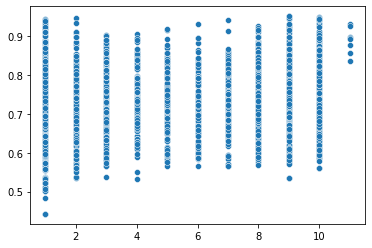

In [27]:
sns.scatterplot(x =all_go_terms.drop(columns = 'Name').count(axis = 1),y = all_go_terms.mean(axis = 1) )

Text(0, 0.5, 'Average Functional Conservation score')

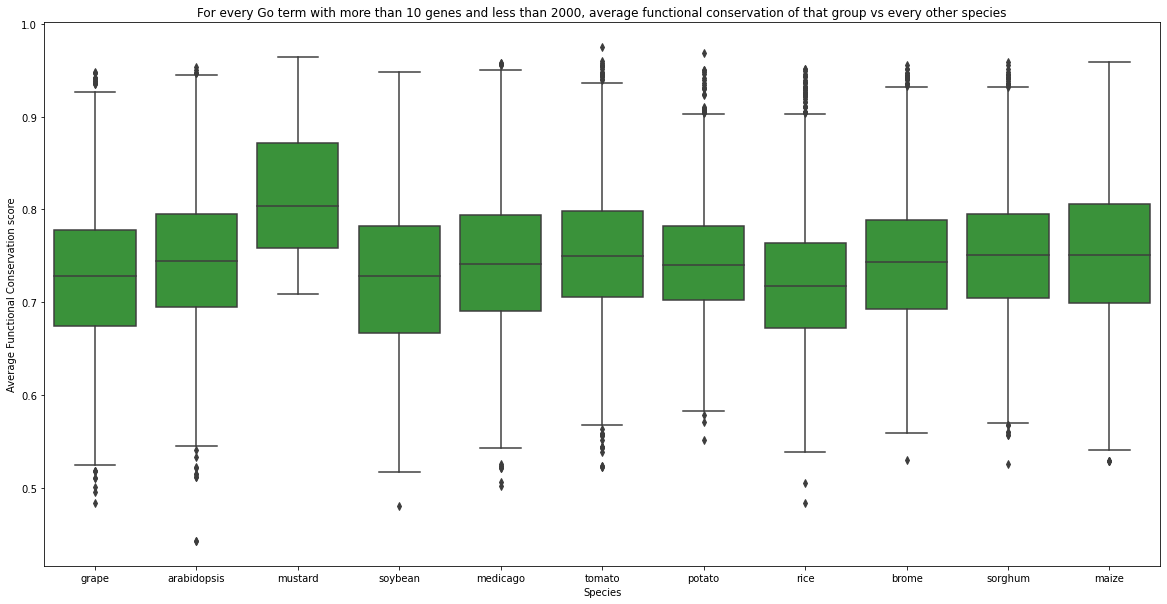

In [28]:
fig, ax = plt.subplots(figsize = (20,10))
sns.boxplot(x="variable", y="value", data=pd.melt(all_go_terms.drop(columns = 'Name')),color = 'tab:green')
plt.title('For every Go term with more than 10 genes and less than 2000, average functional conservation of that group vs every other species')
plt.xlabel('Species')
plt.ylabel('Average Functional Conservation score')

Text(0, 0.5, '# Go groups with between 10 and 2000 genes')

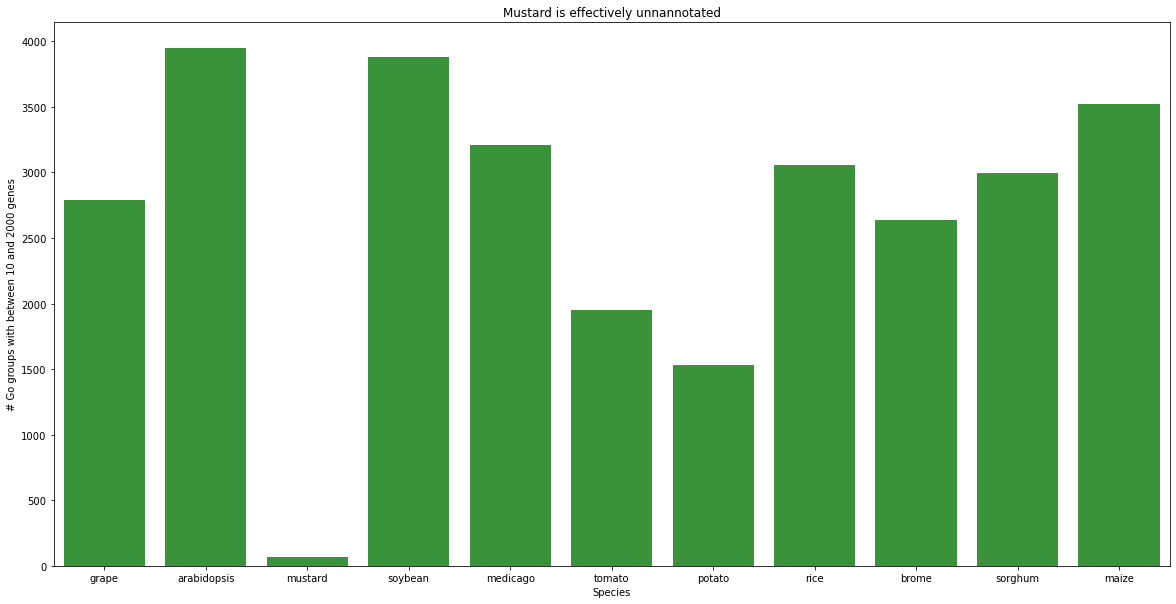

In [26]:
### Why is mustard so high
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = all_go_terms.drop(columns = 'Name').count(axis = 0).index, y = all_go_terms.drop(columns = 'Name').count(axis = 0).to_list(),color = 'tab:green')
plt.title('Mustard is effectively unnannotated')
plt.xlabel('Species')
plt.ylabel('# Go groups with between 10 and 2000 genes')
## Cause there are only 69 annotated groups - why is this? 


In [27]:
all_go_terms.count(axis = 0)

Name           44272
grape           2793
arabidopsis     3949
mustard           69
soybean         3884
medicago        3211
tomato          1954
potato          1528
rice            3057
brome           2637
sorghum         2993
maize           3521
dtype: int64

In [28]:
get_go_annotations_as_panda('mustard')

GO_term     GO:0000003  GO:0000082  GO:0000139  GO:0000160  GO:0000166  \
NetworkIDs                                                               
BCH                0.0         0.0         0.0         0.0         0.0   
CCA1               0.0         0.0         0.0         0.0         0.0   
CHL-CPN10          0.0         0.0         0.0         0.0         0.0   
COPZ1              0.0         0.0         1.0         0.0         0.0   
DHHC1              0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
WRKY22             0.0         0.0         0.0         0.0         0.0   
WRKY3              0.0         0.0         0.0         0.0         0.0   
WRKY67             0.0         0.0         0.0         0.0         0.0   
WRKY7              0.0         0.0         0.0         0.0         0.0   
WRKY74             0.0         0.0         0.0         0.0         0.0   

GO_term     GO:0000278  GO:0000287  GO:0000413  GO:0000502  GO:0000976  ...  \
NetworkIDs                                                              ...   
BCH                0.0         0.0         0.0         0.0         0.0  ...   
CCA1               0.0         0.0         0.0         0.0         0.0  ...   
CHL-CPN10          0.0         0.0         0.0         0.0         0.0  ...   
COPZ1              0.0         0.0         0.0         0.0         0.0  ...   
DHHC1              0.0         0.0         0.0         0.0         0.0  ...   
...                ...         ...         ...         ...         ...  ...   
WRKY22             0.0         0.0         0.0         0.0         0.0  ...   
WRKY3              0.0         0.0         0.0         0.0         0.0  ...   
WRKY67             0.0         0.0         0.0         0.0         0.0  ...   
WRKY7              0.0         0.0         0.0         0.0         0.0  ...   
WRKY74             0.0         0.0         0.0         0.0         0.0  ...   

GO_term     GO:1903506  GO:1903508  GO:1905368  GO:1905369  GO:1990204  \
NetworkIDs                                                               
BCH                0.0         0.0         0.0         0.0         0.0   
CCA1               0.0         0.0         0.0         0.0         0.0   
CHL-CPN10          0.0         0.0         0.0         0.0         0.0   
COPZ1              0.0         0.0         0.0         0.0         0.0   
DHHC1              0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
WRKY22             1.0         0.0         0.0         0.0         0.0   
WRKY3              1.0         0.0         0.0         0.0         0.0   
WRKY67             1.0         0.0         0.0         0.0         0.0   
WRKY7              1.0         0.0         0.0         0.0         0.0   
WRKY74             1.0         0.0         0.0         0.0         0.0   

GO_term     GO:1990748  GO:1990837  GO:1990904  GO:2000112  GO:2001141  
NetworkIDs                                                              
BCH                0.0         0.0         0.0         0.0         0.0  
CCA1               0.0         0.0         0.0         0.0         0.0  
CHL-CPN10          0.0         0.0         0.0         0.0         0.0  
COPZ1              0.0         0.0         0.0         0.0         0.0  
DHHC1              0.0         0.0         0.0         0.0         0.0  
...                ...         ...         ...         ...         ...  
WRKY22             0.0         0.0         0.0         1.0         1.0  
WRKY3              0.0         0.0         0.0         1.0         1.0  
WRKY67             0.0         0.0         0.0         1.0         1.0  
WRKY7              0.0         0.0         0.0         1.0         1.0  
WRKY74             0.0         0.0         0.0         1.0         1.0  

[80 rows x 543 columns]

In [29]:
path_to_orthologs_mapped_pd = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_fc_scores.csv',index_col = 0)
path_to_orthologs_mapped_pd.loc['Vitis vinifera','Brachypodium distachyon']

'/data/suresh/species/CoCoCoNet2/scoresN-M/brome_grape_prio_NM.csv'

In [30]:
def species_name_resolver(species_1,desired_type = 'common'):
    """Takes ambiguous form of species name and returns desired type 

    Args:
        species_1 ([str]): [Ambigious Species Name]
        desired_type (str, optional): [One of common, scientific, or taxa_id]. Defaults to 'common'.

    Returns:
        [str]: [Specified Species ID]
    """

    import pandas as pd
    import numpy as np

    # Assert 
    assert (desired_type in ['common','scientific','taxa_id']), 'Desired type should be common, scientific, or taxa_id'
   
    #Set up variable 
    fc_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Species_name_resolver.csv')

    #Convert Taxa to common names if NCBI taxa ID
    if type(species_1) == int:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_1].item()

    #Convert scientific name to common names if given scientific
    if ' ' in species_1:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_1].item()

    #Get Scientific Name
    scientific_1 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_1].item()
    taxa_id_1 = fc_mapper['Taxa ID'].loc[fc_mapper['Common Name'] == species_1].item()

    if desired_type == 'common':
        return species_1
    elif desired_type =='scientific':
        return scientific_1
    elif desired_type == 'Taxa ID':
        return taxa_id_1




In [31]:
# cococonet_map = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/All_CoCoCoNet_Paths.csv')
# all_go_group_egad_results = pd.DataFrame(index = all_go_terms.index)
# for species in coconet_plants:
#     print(species)
#     combos_that_start_with_species = []
#     current_species_path_cococonet = cococonet_map['Path'].loc[cococonet_map['Common Name'] == species].item()
#     for combo in plant_combinations:
#         if combo[0] == species:
#             combos_that_start_with_species.append(combo)
#     current_species_annotations = get_go_annotations_as_panda(species)
#     go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     go_groups_for_egad = go_groups_with_counts.index.to_list()
#     annotations_to_run_egad_on = current_species_annotations[go_groups_for_egad]
#     current_scientific_name = species_name_resolver(species_1 = species,desired_type = 'scientific') 
#     current_cococonet = read_cococonet(current_species_path_cococonet)
#     egad_results = run_egad(go = annotations_to_run_egad_on, nw = current_cococonet,min_count =10, max_count = 2000 )
#     all_go_group_egad_results = all_go_group_egad_results.merge(right = egad_results[['AUC','P_Value']], how = 'left', left_index= True,right_index= True)
#     all_go_group_egad_results = all_go_group_egad_results.rename(columns = {'AUC':'{} AUC'.format(species),'P_Value':'{} P_Value'.format(species)})

In [32]:
# all_go_group_egad_results.to_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/egad_results_for_go_terms_in_each_species')

In [33]:
all_go_group_egad_results = pd.read_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/egad_results_for_go_terms_in_each_species',index_col= 0)

In [34]:
all_go_group_egad_results

grape AUC  grape P_Value  arabidopsis AUC  arabidopsis P_Value  \
GO:0000001        NaN            NaN              NaN                  NaN   
GO:0000002        NaN            NaN              NaN                  NaN   
GO:0000003   0.625412   2.529527e-15         0.637415         7.013306e-77   
GO:0000006        NaN            NaN              NaN                  NaN   
GO:0000007        NaN            NaN              NaN                  NaN   
...               ...            ...              ...                  ...   
GO:0051184        NaN            NaN         0.418488         1.177666e-01   
GO:0051194        NaN            NaN         0.739692         2.103215e-03   
GO:0051182        NaN            NaN         0.517158         3.518054e-01   
GO:0051185        NaN            NaN         0.542371         2.974942e-01   
GO:0018065        NaN            NaN              NaN                  NaN   

            mustard AUC  mustard P_Value  soybean AUC  soybean P_Value  \
GO:0000001          NaN              NaN          NaN              NaN   
GO:0000002          NaN              NaN          NaN              NaN   
GO:0000003          NaN              NaN     0.661435     7.142421e-21   
GO:0000006          NaN              NaN          NaN              NaN   
GO:0000007          NaN              NaN          NaN              NaN   
...                 ...              ...          ...              ...   
GO:0051184          NaN              NaN     0.657711     1.444694e-02   
GO:0051194          NaN              NaN          NaN              NaN   
GO:0051182          NaN              NaN     0.666193     1.414141e-02   
GO:0051185          NaN              NaN     0.666193     1.414141e-02   
GO:0018065          NaN              NaN     0.771988     2.004492e-04   

            medicago AUC  medicago P_Value  ...  potato AUC  potato P_Value  \
GO:0000001           NaN               NaN  ...         NaN             NaN   
GO:0000002           NaN               NaN  ...         NaN             NaN   
GO:0000003      0.632426      8.404561e-28  ...    0.589024        0.000012   
GO:0000006           NaN               NaN  ...         NaN             NaN   
GO:0000007           NaN               NaN  ...         NaN             NaN   
...                  ...               ...  ...         ...             ...   
GO:0051184           NaN               NaN  ...         NaN             NaN   
GO:0051194           NaN               NaN  ...         NaN             NaN   
GO:0051182           NaN               NaN  ...         NaN             NaN   
GO:0051185           NaN               NaN  ...         NaN             NaN   
GO:0018065           NaN               NaN  ...         NaN             NaN   

            rice AUC  rice P_Value  brome AUC  brome P_Value  sorghum AUC  \
GO:0000001       NaN           NaN        NaN            NaN          NaN   
GO:0000002       NaN           NaN        NaN            NaN          NaN   
GO:0000003  0.602575  1.152586e-17     0.6588   3.478783e-19     0.633467   
GO:0000006       NaN           NaN        NaN            NaN          NaN   
GO:0000007       NaN           NaN        NaN            NaN          NaN   
...              ...           ...        ...            ...          ...   
GO:0051184  0.713925  1.369462e-02        NaN            NaN     0.567056   
GO:0051194       NaN           NaN        NaN            NaN          NaN   
GO:0051182  0.687753  3.747406e-02        NaN            NaN     0.549651   
GO:0051185  0.697465  2.815103e-02        NaN            NaN     0.549651   
GO:0018065       NaN           NaN        NaN            NaN          NaN   

            sorghum P_Value  maize AUC  maize P_Value  
GO:0000001              NaN        NaN            NaN  
GO:0000002              NaN        NaN            NaN  
GO:0000003     3.448212e-21   0.656936   1.964086e-27  
GO:0000006              NaN        NaN            NaN  
GO:0000007              NaN     

In [35]:
all_egad_results = all_go_group_egad_results[['grape AUC','arabidopsis AUC','soybean AUC','medicago AUC','tomato AUC','potato AUC','rice AUC','brome AUC','sorghum AUC','maize AUC']]

Text(0, 0.5, 'EGAD Score')

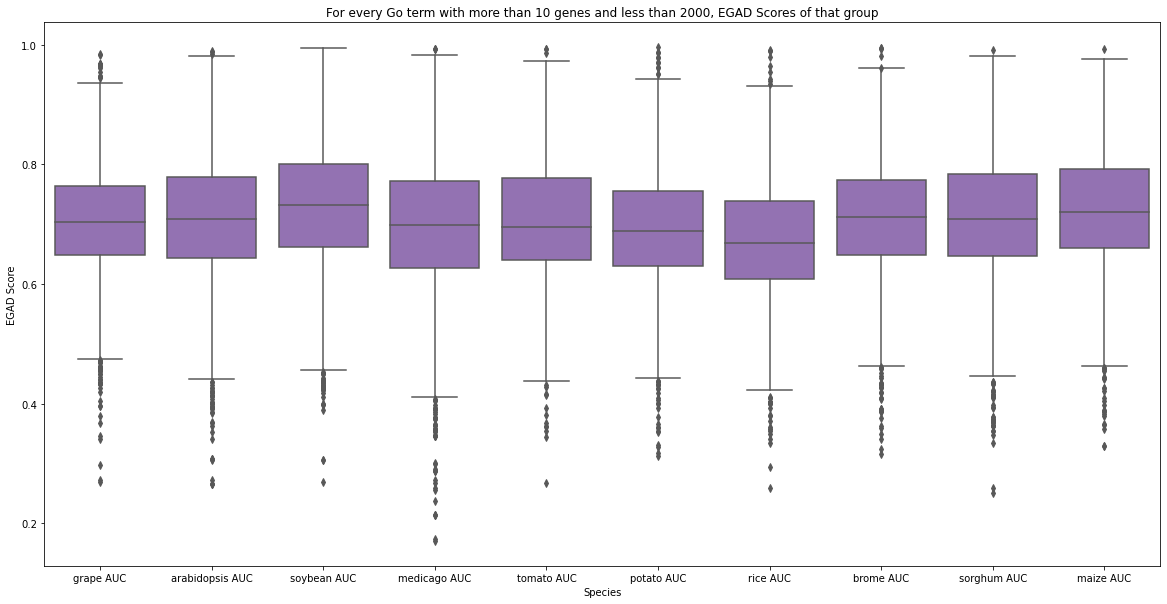

In [36]:
fig, ax = plt.subplots(figsize = (20,10))
sns.boxplot(x="variable", y="value", data=pd.melt(all_egad_results),color = 'tab:purple')
plt.title('For every Go term with more than 10 genes and less than 2000, EGAD Scores of that group')
plt.xlabel('Species')
plt.ylabel('EGAD Score')

In [37]:
egad_means = all_egad_results.mean(axis = 1)
egad_means

GO:0000001         NaN
GO:0000002         NaN
GO:0000003    0.634227
GO:0000006         NaN
GO:0000007         NaN
                ...   
GO:0051184    0.598399
GO:0051194    0.739692
GO:0051182    0.607253
GO:0051185    0.614238
GO:0018065    0.771988
Length: 44290, dtype: float64

In [38]:
average_functional_conservation_for_each_term

GO:0000001         NaN
GO:0000002         NaN
GO:0000003    0.740324
GO:0000006         NaN
GO:0000007         NaN
                ...   
GO:0051184    0.746524
GO:0051194    0.815936
GO:0051182    0.744765
GO:0051185    0.749290
GO:0018065    0.716085
Length: 44290, dtype: float64

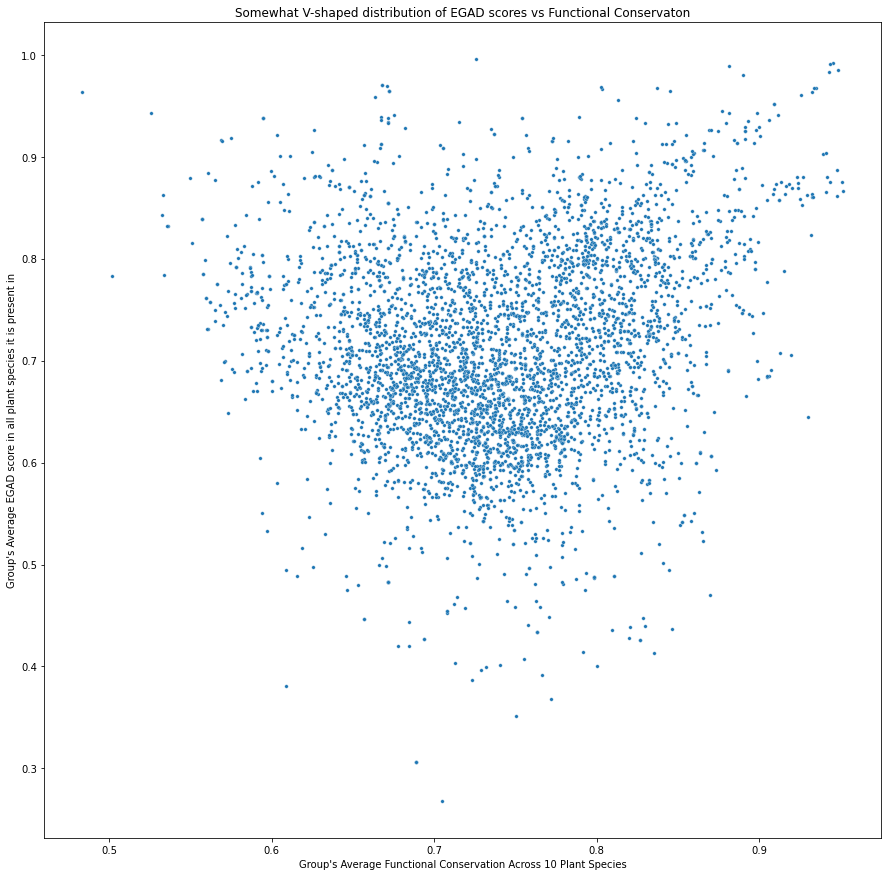

In [39]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(x = average_functional_conservation_for_each_term,y = egad_means,s = 13)
plt.xlabel("Group's Average Functional Conservation Across 10 Plant Species")
plt.ylabel("Group's Average EGAD score in all plant species it is present in")
plt.title("Somewhat V-shaped distribution of EGAD scores vs Functional Conservaton")
plt.savefig('/home/passala/Gene_duplication_project/Figures/April_week_1_plots/overall_plot')


In [40]:
groups_with_values = pd.concat([average_functional_conservation_for_each_term,egad_means],axis = 1)
groups_with_values = groups_with_values.rename(columns = {0:'Avg FC',1:'Avg EGAD'})
groups_with_values = groups_with_values.merge(right = all_go_terms['Name'],left_index = True,right_index = True)
low_fc_high_egad = groups_with_values.loc[groups_with_values['Avg EGAD']>.8]
low_fc_high_egad = low_fc_high_egad.loc[low_fc_high_egad['Avg FC']<.6]
low_fc_high_egad

Avg FC  Avg EGAD  \
GO:0000250  0.594456  0.937953   
GO:0004364  0.578591  0.809822   
GO:0006863  0.594339  0.803498   
GO:0008271  0.598048  0.856025   
GO:0008515  0.581364  0.806464   
GO:0010168  0.592008  0.839195   
GO:0010325  0.582909  0.812457   
GO:0010439  0.577620  0.832698   
GO:0015112  0.584488  0.843206   
GO:0015333  0.588562  0.804464   
GO:0016145  0.557058  0.838941   
GO:0016165  0.525607  0.943362   
GO:0016709  0.579626  0.801142   
GO:0019139  0.572496  0.822097   
GO:0019759  0.557058  0.838941   
GO:0019762  0.557058  0.838941   
GO:0031407  0.591734  0.875337   
GO:0031408  0.588121  0.871586   
GO:0031559  0.594456  0.937953   
GO:0042300  0.594456  0.937953   
GO:0042343  0.533535  0.862343   
GO:0045337  0.599640  0.886167   
GO:0045551  0.549677  0.879144   
GO:0047172  0.568828  0.916749   
GO:0050734  0.575145  0.918810   
GO:0050737  0.569313  0.915775   
GO:0051501  0.483574  0.963969   
GO:0051761  0.532711  0.842890   
GO:0051762  0.565138  0.876793   
GO:0052747  0.560985  0.883852   
GO:0071732  0.551139  0.815612   
GO:0080043  0.536043  0.831681   
GO:0080044  0.535982  0.832378   
GO:1904823  0.594339  0.803498   

                                                         Name  
GO:0000250                       lanosterol synthase activity  
GO:0004364                   glutathione transferase activity  
GO:0006863                        purine nucleobase transport  
GO:0008271  secondary active sulfate transmembrane transpo...  
GO:0008515         sucrose transmembrane transporter activity  
GO:0010168                                            ER body  
GO:0010325  raffinose family oligosaccharide biosynthetic ...  
GO:0010439   regulation of glucosinolate biosynthetic process  
GO:0015112         nitrate transmembrane transporter activity  
GO:0015333                  peptide:proton symporter activity  
GO:0016145                      S-glycoside catabolic process  
GO:0016165                linoleate 13S-lipoxygenase activity  
GO:0016709  oxidoreductase activity, acting on paired dono...  
GO:0019139                   cytokinin dehydrogenase activity  
GO:0019759                    glycosinolate catabolic process  
GO:0019762                    glucosinolate catabolic process  
GO:0031407                         oxylipin metabolic process  
GO:0031408                      oxylipin biosynthetic process  
GO:0031559                     oxidosqualene cyclase activity  
GO:0042300                      beta-amyrin synthase activity  
GO:0042343             indole glucosinolate metabolic process  
GO:0045337          farnesyl diphosphate biosynthetic process  
GO:0045551            cinnamyl-alcohol dehydrogenase activity  
GO:0047172   shikimate O-hydroxycinnamoyltransferase activity  
GO:0050734               hydroxycinnamoyltransferase activity  
GO:0050737             O-hydroxycinnamoyltransferase activity  
GO:0051501            diterpene phytoalexin metabolic process  
GO:0051761                    sesquiterpene metabolic process  
GO:0051762                 sesquiterpene biosynthetic process  
GO:0052747             sinapyl alcohol dehydrogenase activity  
GO:0071732                  cellular response to nitric oxide  
GO:0080043         quercetin 3-O-glucosyltransferase activity  
GO:0080044         quercetin 7-O-glucosyltransferase activity  
GO:1904823          purine nucleobase transmembrane transport

In [41]:
### Are the high EGAD only present in a few groups???

#Color by number of groups its in, need third and fourth columns with those values

In [42]:
groups_with_values['EGAD Counts'] = all_egad_results.count(axis =1).to_list()
groups_with_values

Avg FC  Avg EGAD  \
GO:0000001       NaN       NaN   
GO:0000002       NaN       NaN   
GO:0000003  0.740324  0.634227   
GO:0000006       NaN       NaN   
GO:0000007       NaN       NaN   
...              ...       ...   
GO:0051184  0.746524  0.598399   
GO:0051194  0.815936  0.739692   
GO:0051182  0.744765  0.607253   
GO:0051185  0.749290  0.614238   
GO:0018065  0.716085  0.771988   

                                                         Name  EGAD Counts  
GO:0000001                          mitochondrion inheritance            0  
GO:0000002                   mitochondrial genome maintenance            0  
GO:0000003                                       reproduction           10  
GO:0000006  high-affinity zinc transmembrane transporter a...            0  
GO:0000007  low-affinity zinc ion transmembrane transporte...            0  
...                                                       ...          ...  
GO:0051184                                                NaN            5  
GO:0051194                                                NaN            1  
GO:0051182                                                NaN            5  
GO:0051185                                                NaN            5  
GO:0018065                                                NaN            1  

[44290 rows x 4 columns]

In [43]:
number_of_groups_for_each_go_term

GO:0000001     0
GO:0000002     0
GO:0000003    10
GO:0000006     0
GO:0000007     0
              ..
GO:0051184     6
GO:0051194     1
GO:0051182     5
GO:0051185     5
GO:0018065     1
Length: 44290, dtype: int64

Text(0.5, 1.0, 'Somewhat V-shaped distribution of EGAD scores vs Functional Conservaton')

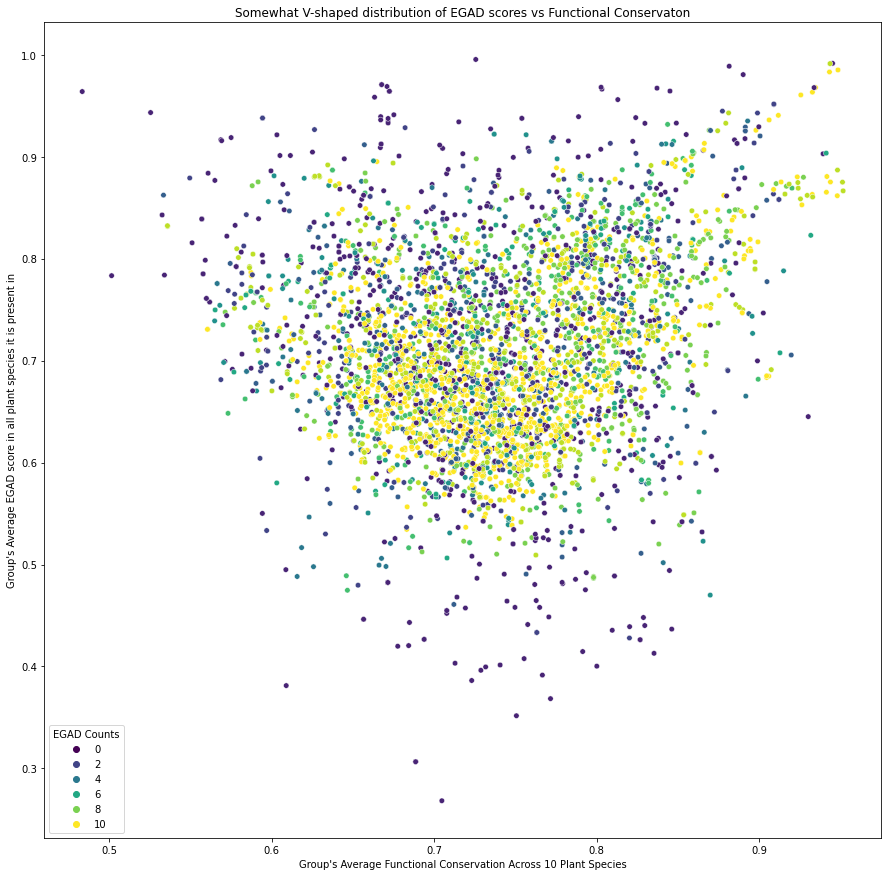

In [44]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = groups_with_values,x = 'Avg FC',y = 'Avg EGAD',s = 30, hue = 'EGAD Counts',palette = 'viridis')
plt.xlabel("Group's Average Functional Conservation Across 10 Plant Species")
plt.ylabel("Group's Average EGAD score in all plant species it is present in")
plt.title("Somewhat V-shaped distribution of EGAD scores vs Functional Conservaton")

In [45]:
filtered_groups_with_values = groups_with_values.loc[groups_with_values['EGAD Counts']>3]
filtered_groups_with_values

Avg FC  Avg EGAD                              Name  EGAD Counts
GO:0000003  0.740324  0.634227                      reproduction           10
GO:0000018  0.766573  0.798689   regulation of DNA recombination            8
GO:0000027  0.923946  0.869159  ribosomal large subunit assembly            9
GO:0000028  0.951180  0.875073  ribosomal small subunit assembly            9
GO:0000030  0.714718  0.642678      mannosyltransferase activity            8
...              ...       ...                               ...          ...
GO:0051181  0.732571  0.655892                               NaN            8
GO:0051193  0.734276  0.660798                               NaN            4
GO:0051184  0.746524  0.598399                               NaN            5
GO:0051182  0.744765  0.607253                               NaN            5
GO:0051185  0.749290  0.614238                               NaN            5

[3011 rows x 4 columns]

In [46]:
filtered_groups_with_values['Annotation'] = 'None'

/tmp/ipykernel_2284015/3465865493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_groups_with_values['Annotation'] = 'None'


In [47]:
filtered_groups_with_values.loc[(filtered_groups_with_values['Avg FC'] <.66) & (filtered_groups_with_values['Avg EGAD']>.85)]

Avg FC  Avg EGAD  \
GO:0004568  0.657568  0.884087   
GO:0004866  0.626294  0.880106   
GO:0004867  0.635185  0.871857   
GO:0005372  0.637481  0.886895   
GO:0008271  0.598048  0.856025   
GO:0009695  0.655312  0.875871   
GO:0010143  0.620090  0.878869   
GO:0010333  0.601552  0.881313   
GO:0010466  0.629580  0.880257   
GO:0010951  0.629263  0.881417   
GO:0015250  0.637481  0.886895   
GO:0016762  0.634570  0.891974   
GO:0030414  0.626630  0.880892   
GO:0031407  0.591734  0.875337   
GO:0031408  0.588121  0.871586   
GO:0044347  0.657549  0.864538   
GO:0045861  0.636035  0.876339   
GO:0052548  0.641517  0.873605   
GO:0061135  0.639283  0.871639   
GO:0080163  0.657926  0.876039   

                                                         Name  EGAD Counts  \
GO:0004568                                 chitinase activity            8   
GO:0004866                   endopeptidase inhibitor activity            9   
GO:0004867       serine-type endopeptidase inhibitor activity            5   
GO:0005372           water transmembrane transporter activity            7   
GO:0008271  secondary active sulfate transmembrane transpo...            5   
GO:0009695                 jasmonic acid biosynthetic process            4   
GO:0010143                         cutin biosynthetic process            5   
GO:0010333                          terpene synthase activity            5   
GO:0010466          negative regulation of peptidase activity            9   
GO:0010951      negative regulation of endopeptidase activity            9   
GO:0015250                             water channel activity            7   
GO:0016762       xyloglucan:xyloglucosyl transferase activity            9   
GO:0030414                       peptidase inhibitor activity            9   
GO:0031407                         oxylipin metabolic process            8   
GO:0031408                      oxylipin biosynthetic process            8   
GO:0044347         cell wall polysaccharide catabolic process            7   
GO:0045861                 negative regulation of proteolysis           10   
GO:0052548               regulation of endopeptidase activity           10   
GO:0061135                   endopeptidase regulator activity            9   
GO:0080163  regulation of protein serine/threonine phospha...            8   

           Annotation  
GO:0004568       None  
GO:0004866       None  
GO:0004867       None  
GO:0005372       None  
GO:0008271       None  
GO:0009695       None  
GO:0010143       None  
GO:0010333       None  
GO:0010466       None  
GO:0010951       None  
GO:0015250       None  
GO:0016762       None  
GO:0030414       None  
GO:0031407       None  
GO:0031408       None  
GO:0044347       None  
GO:0045861       None  
GO:0052548       None  
GO:0061135       None  
GO:0080163       None

In [48]:
secondary_go_values_to_annotate = ['GO:0080044','GO:0080043','GO:0016102','GO:0016101','GO:0080031','GO:0080032','GO:0016102','GO:0031408','GO:0031407','GO:0008271','GO:0009695','GO:0010143','GO:0010333']
plant_hormone = ['GO:0009686','GO:0080032','GO:0010268','GO:0009691','GO:0080030','GO:0009685','GO:0009690']
ribosomal_annotate = ['GO:0022627','GO:0000028','GO:0022625','GO:0015935','GO:0044391','GO:0015934','GO:0022626','GO:0070180','GO:0042274','GO:0003735','GO:0000462','GO:0070181','GO:0030490','GO:0000463','GO:0005840','GO:0000470','GO:0000027','GO:0030686','GO:0042273','GO:0000479','GO:0032040','GO:0042255','GO:0000314','GO:0019843','GO:0000478','GO:0030684','GO:0005732','GO:0030687']
photosynthesis_annotate = ['GO:0009522','GO:0009768','GO:0016168','GO:0009765','GO:0009521','GO:0009523','GO:0019684','GO:0009654']

In [49]:
filtered_groups_with_values.sort_values(by = 'Avg FC')


Avg FC  Avg EGAD  \
GO:0080044  0.535982  0.832378   
GO:0080043  0.536043  0.831681   
GO:0042910  0.560573  0.730711   
GO:0042908  0.560821  0.730755   
GO:0009686  0.565007  0.739009   
...              ...       ...   
GO:0009522  0.948384  0.985165   
GO:0000028  0.951180  0.875073   
GO:0022627  0.951587  0.866551   
GO:0016837       NaN  0.817884   
GO:0030570       NaN  0.822899   

                                                         Name  EGAD Counts  \
GO:0080044         quercetin 7-O-glucosyltransferase activity            9   
GO:0080043         quercetin 3-O-glucosyltransferase activity            9   
GO:0042910      xenobiotic transmembrane transporter activity           10   
GO:0042908                               xenobiotic transport           10   
GO:0009686                   gibberellin biosynthetic process            5   
...                                                       ...          ...   
GO:0009522                                      photosystem I           10   
GO:0000028                   ribosomal small subunit assembly            9   
GO:0022627                  cytosolic small ribosomal subunit            9   
GO:0016837  carbon-oxygen lyase activity, acting on polysa...            5   
GO:0030570                             pectate lyase activity            5   

           Annotation  
GO:0080044       None  
GO:0080043       None  
GO:0042910       None  
GO:0042908       None  
GO:0009686       None  
...               ...  
GO:0009522       None  
GO:0000028       None  
GO:0022627       None  
GO:0016837       None  
GO:0030570       None  

[3011 rows x 5 columns]

In [50]:
filtered_groups_with_values['Annotation'].loc[filtered_groups_with_values.index.isin(ribosomal_annotate)] = 'Ribosomal'
filtered_groups_with_values['Annotation'].loc[filtered_groups_with_values.index.isin(photosynthesis_annotate)] = 'Photosynthesis'
filtered_groups_with_values['Annotation'].loc[filtered_groups_with_values.index.isin(secondary_go_values_to_annotate)] = 'Secondary Metabolism'
filtered_groups_with_values['Annotation'].loc[filtered_groups_with_values.index.isin(plant_hormone)] = 'Hormonal'




/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [51]:
filtered_groups_with_values

Avg FC  Avg EGAD                              Name  EGAD Counts  \
GO:0000003  0.740324  0.634227                      reproduction           10   
GO:0000018  0.766573  0.798689   regulation of DNA recombination            8   
GO:0000027  0.923946  0.869159  ribosomal large subunit assembly            9   
GO:0000028  0.951180  0.875073  ribosomal small subunit assembly            9   
GO:0000030  0.714718  0.642678      mannosyltransferase activity            8   
...              ...       ...                               ...          ...   
GO:0051181  0.732571  0.655892                               NaN            8   
GO:0051193  0.734276  0.660798                               NaN            4   
GO:0051184  0.746524  0.598399                               NaN            5   
GO:0051182  0.744765  0.607253                               NaN            5   
GO:0051185  0.749290  0.614238                               NaN            5   

           Annotation  
GO:0000003       None  
GO:0000018       None  
GO:0000027  Ribosomal  
GO:0000028  Ribosomal  
GO:0000030       None  
...               ...  
GO:0051181       None  
GO:0051193       None  
GO:0051184       None  
GO:0051182       None  
GO:0051185       None  

[3011 rows x 5 columns]

In [52]:
annotated_groups_to_plot = filtered_groups_with_values.loc[filtered_groups_with_values['Annotation'] != 'None']
annotated_groups_to_plot

Avg FC  Avg EGAD  \
GO:0000027  0.923946  0.869159   
GO:0000028  0.951180  0.875073   
GO:0000314  0.914939  0.788085   
GO:0000462  0.932444  0.860870   
GO:0000463  0.927158  0.879880   
GO:0000470  0.925322  0.858711   
GO:0000478  0.910370  0.873684   
GO:0000479  0.920105  0.869224   
GO:0003735  0.932589  0.863066   
GO:0005732  0.901494  0.872746   
GO:0005840  0.926189  0.852841   
GO:0008271  0.598048  0.856025   
GO:0009521  0.932681  0.963350   
GO:0009522  0.948384  0.985165   
GO:0009523  0.925535  0.960610   
GO:0009654  0.897917  0.925997   
GO:0009685  0.583506  0.751984   
GO:0009686  0.565007  0.739009   
GO:0009690  0.583757  0.662429   
GO:0009691  0.576860  0.688781   
GO:0009695  0.655312  0.875871   
GO:0009765  0.934619  0.967893   
GO:0009768  0.943499  0.991352   
GO:0010143  0.620090  0.878869   
GO:0010268  0.571501  0.747605   
GO:0010333  0.601552  0.881313   
GO:0015934  0.941579  0.880610   
GO:0015935  0.947993  0.861761   
GO:0016101  0.584266  0.764391   
GO:0016102  0.568173  0.754264   
GO:0016168  0.943177  0.983172   
GO:0019684  0.911722  0.940628   
GO:0019843  0.913419  0.875238   
GO:0022625  0.948101  0.886950   
GO:0022626  0.941278  0.865211   
GO:0022627  0.951587  0.866551   
GO:0030490  0.929463  0.862114   
GO:0030684  0.908788  0.867913   
GO:0030686  0.923709  0.874706   
GO:0030687  0.898174  0.850059   
GO:0031407  0.591734  0.875337   
GO:0031408  0.588121  0.871586   
GO:0032040  0.918376  0.873157   
GO:0042255  0.915785  0.863369   
GO:0042273  0.923381  0.880276   
GO:0042274  0.932844  0.860562   
GO:0044391  0.943757  0.875246   
GO:0070180  0.941159  0.903541   
GO:0070181  0.931659  0.822929   
GO:0080030  0.570538  0.698227   
GO:0080031  0.566563  0.775655   
GO:0080032  0.566563  0.775655   
GO:0080043  0.536043  0.831681   
GO:0080044  0.535982  0.832378   

                                                         Name  EGAD Counts  \
GO:0000027                   ribosomal large subunit assembly            9   
GO:0000028                   ribosomal small subunit assembly            9   
GO:0000314                 organellar small ribosomal subunit            5   
GO:0000462  maturation of SSU-rRNA from tricistronic rRNA ...            9   
GO:0000463  maturation of LSU-rRNA from tricistronic rRNA ...            8   
GO:0000470                             maturation of LSU-rRNA            9   
GO:0000478  endonucleolytic cleavage involved in rRNA proc...            8   
GO:0000479  endonucleolytic cleavage of tricistronic rRNA ...            7   
GO:0003735                 structural constituent of ribosome           10   
GO:0005732          small nucleolar ribonucleoprotein complex            8   
GO:0005840                                           ribosome           10   
GO:0008271  secondary active sulfate transmembrane transpo...            5   
GO:0009521                                        photosystem           10   
GO:0009522                                      photosystem I           10   
GO:0009523                                     photosystem II           10   
GO:0009654             photosystem II oxygen evolving complex           10   
GO:0009685                      gibberellin metabolic process            6   
GO:0009686                   gibberellin biosynthetic process            5   
GO:0009690                        cytokinin metabolic process            7   
GO:0009691                     cytokinin biosynthetic process            6   
GO:0009695                 jasmonic acid biosynthetic process            4   
GO:0009765                   photosynthesis, light harvesting           10   
GO:0009768  photosynthesis, light harvesting in photosystem I            9   
GO:0010143                         cutin biosynthetic process            5   
GO:0010268                        brassinosteroid homeostasis            8   
GO:0010333                          terpene synthase activity            5   
GO:0015934                           

In [53]:
#filtered_groups_with_values.sort_values(by= 'Avg FC',ascending = True).head(50)

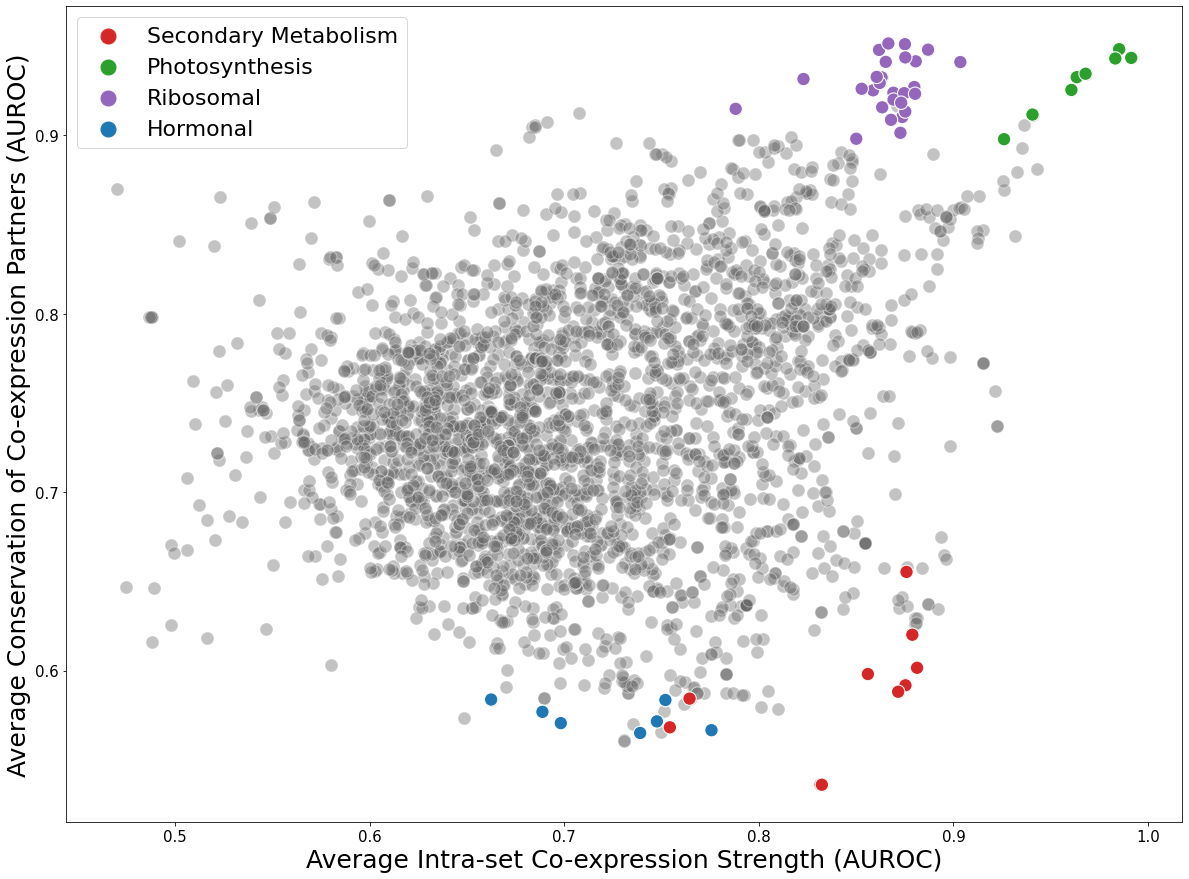

In [54]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = filtered_groups_with_values,y = 'Avg FC',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4 )
sns.scatterplot(data = annotated_groups_to_plot, x = 'Avg EGAD',y = 'Avg FC',s = 180, hue = 'Annotation', hue_order =['Secondary Metabolism','Photosynthesis','Ribosomal','Hormonal'], palette = ['tab:red','tab:green','tab:purple','tab:blue'])

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Co-expression Strength (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [55]:
full_annotated_group_list = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/all_annotated_go_groups.csv',encoding = 'cp1252',index_col= 0)
full_annotated_group_list

Avg FC  Avg EGAD  \
GO:0000003  0.740324  0.634227   
GO:0000018  0.766573  0.798689   
GO:0000027  0.923946  0.869159   
GO:0000028  0.951180  0.875073   
GO:0000030  0.714718  0.642678   
...              ...       ...   
GO:2001020  0.821085  0.761272   
GO:2001070  0.720227  0.869219   
GO:2001141  0.722697  0.673483   
GO:2001251  0.778751  0.805120   
GO:2001252  0.821120  0.790655   

                                                      Name  EGAD Counts  \
GO:0000003                                    reproduction           10   
GO:0000018                 regulation of DNA recombination            8   
GO:0000027                ribosomal large subunit assembly            9   
GO:0000028                ribosomal small subunit assembly            9   
GO:0000030                    mannosyltransferase activity            8   
...                                                    ...          ...   
GO:2001020   regulation of response to DNA damage stimulus            9   
GO:2001070                                  starch binding            7   
GO:2001141          regulation of RNA biosynthetic process            6   
GO:2001251  negative regulation of chromosome organization            9   
GO:2001252  positive regulation of chromosome organization            8   

           Annotation                            Notes  
GO:0000003       None                              NaN  
GO:0000018       None                              NaN  
GO:0000027  Ribosomal                              NaN  
GO:0000028  Ribosomal                              NaN  
GO:0000030       None  Critical function in eukaryotes  
...               ...                              ...  
GO:2001020       None                              NaN  
GO:2001070       None                              NaN  
GO:2001141       None                              NaN  
GO:2001251       None                              NaN  
GO:2001252       None                              NaN  

[3011 rows x 6 columns]

In [56]:
all_annotated_groups_to_plot = full_annotated_group_list.loc[full_annotated_group_list['Annotation'] != 'None']
all_annotated_groups_to_plot

Avg FC  Avg EGAD                                         Name  \
GO:0000027  0.923946  0.869159             ribosomal large subunit assembly   
GO:0000028  0.951180  0.875073             ribosomal small subunit assembly   
GO:0000054  0.813080  0.767277        ribosomal subunit export from nucleus   
GO:0000055  0.868017  0.824231  ribosomal large subunit export from nucleus   
GO:0000154  0.878154  0.862114                            rRNA modification   
...              ...       ...                                          ...   
GO:0140102  0.867476  0.790179         catalytic activity, acting on a rRNA   
GO:1900750  0.587250  0.768058                         oligopeptide binding   
GO:1901259  0.858876  0.905425                  chloroplast rRNA processing   
GO:1901661  0.752271  0.742225                    quinone metabolic process   
GO:1901663  0.752271  0.743349                 quinone biosynthetic process   

            EGAD Counts            Annotation Notes  
GO:0000027            9             Ribosomal   NaN  
GO:0000028            9             Ribosomal   NaN  
GO:0000054            8             Ribosomal   NaN  
GO:0000055            4             Ribosomal   NaN  
GO:0000154           10             Ribosomal   NaN  
...                 ...                   ...   ...  
GO:0140102            8             Ribosomal   NaN  
GO:1900750            6              Hormonal   NaN  
GO:1901259            7             Ribosomal   NaN  
GO:1901661            9  Secondary Metabolism   NaN  
GO:1901663            9  Secondary Metabolism   NaN  

[164 rows x 6 columns]

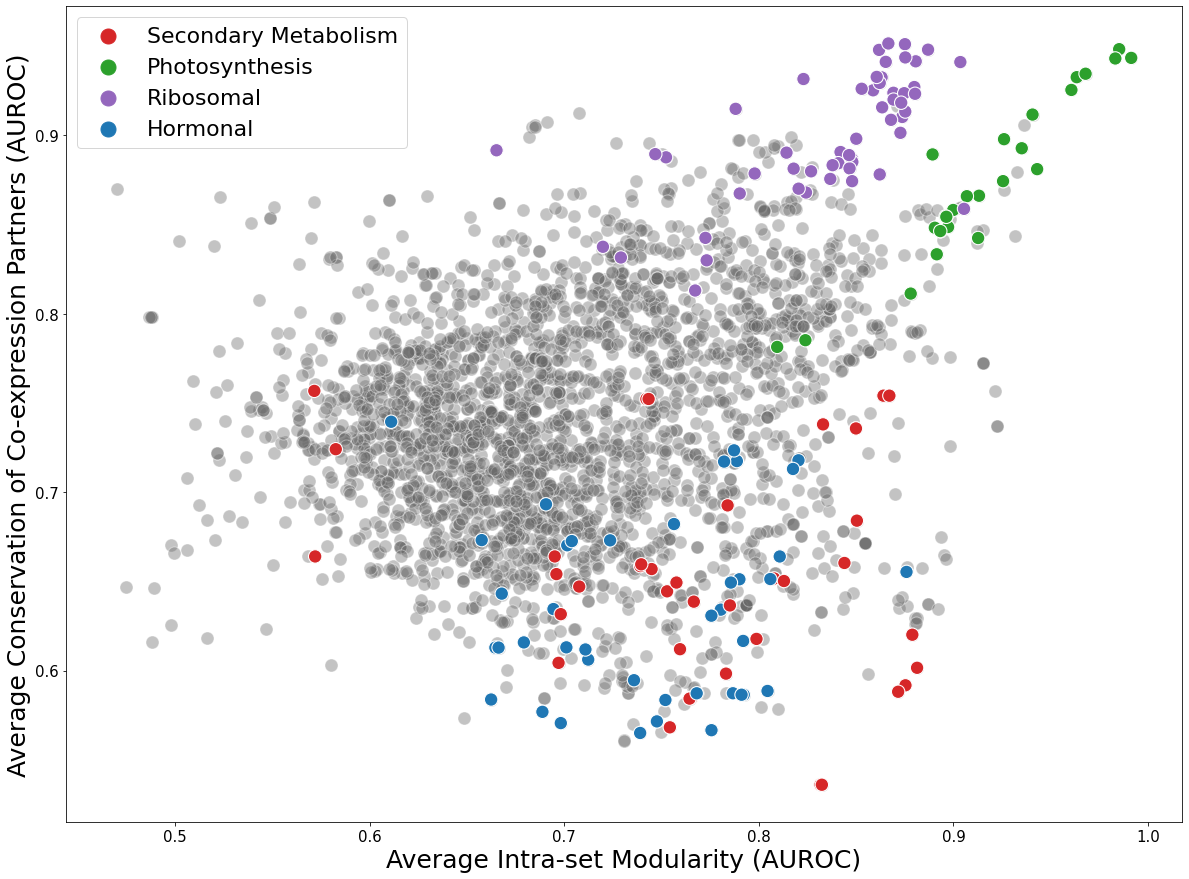

In [57]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = filtered_groups_with_values,y = 'Avg FC',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4)
sns.scatterplot(data = all_annotated_groups_to_plot, x = 'Avg EGAD',y = 'Avg FC',s = 180, hue = 'Annotation', hue_order =['Secondary Metabolism','Photosynthesis','Ribosomal','Hormonal'], palette = ['tab:red','tab:green','tab:purple','tab:blue'],)

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

In [58]:
full_annotated_group_list

Avg FC  Avg EGAD  \
GO:0000003  0.740324  0.634227   
GO:0000018  0.766573  0.798689   
GO:0000027  0.923946  0.869159   
GO:0000028  0.951180  0.875073   
GO:0000030  0.714718  0.642678   
...              ...       ...   
GO:2001020  0.821085  0.761272   
GO:2001070  0.720227  0.869219   
GO:2001141  0.722697  0.673483   
GO:2001251  0.778751  0.805120   
GO:2001252  0.821120  0.790655   

                                                      Name  EGAD Counts  \
GO:0000003                                    reproduction           10   
GO:0000018                 regulation of DNA recombination            8   
GO:0000027                ribosomal large subunit assembly            9   
GO:0000028                ribosomal small subunit assembly            9   
GO:0000030                    mannosyltransferase activity            8   
...                                                    ...          ...   
GO:2001020   regulation of response to DNA damage stimulus            9   
GO:2001070                                  starch binding            7   
GO:2001141          regulation of RNA biosynthetic process            6   
GO:2001251  negative regulation of chromosome organization            9   
GO:2001252  positive regulation of chromosome organization            8   

           Annotation                            Notes  
GO:0000003       None                              NaN  
GO:0000018       None                              NaN  
GO:0000027  Ribosomal                              NaN  
GO:0000028  Ribosomal                              NaN  
GO:0000030       None  Critical function in eukaryotes  
...               ...                              ...  
GO:2001020       None                              NaN  
GO:2001070       None                              NaN  
GO:2001141       None                              NaN  
GO:2001251       None                              NaN  
GO:2001252       None                              NaN  

[3011 rows x 6 columns]

In [59]:
arab_go_groups_for_primary_annotaion = get_go_annotations_as_panda('arabidopsis')
arab_go_groups_for_primary_annotaion = arab_go_groups_for_primary_annotaion[arab_go_groups_for_primary_annotaion.columns.intersection(full_annotated_group_list.index.to_list())]
arab_go_groups_for_primary_annotaion

GO_term     GO:0000003  GO:0000018  GO:0000027  GO:0000028  GO:0000030  \
NetworkIDs                                                               
AT1G01010          0.0         0.0         0.0         0.0         0.0   
AT1G01020          0.0         0.0         0.0         0.0         0.0   
AT1G01030          1.0         0.0         0.0         0.0         0.0   
AT1G01040          1.0         0.0         0.0         0.0         0.0   
AT1G01046          0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0   
ATMG01360          0.0         0.0         0.0         0.0         0.0   
ATMG01370          0.0         0.0         0.0         0.0         0.0   
ATMG01400          0.0         0.0         0.0         0.0         0.0   
ATMG01410          0.0         0.0         0.0         0.0         0.0   

GO_term     GO:0000036  GO:0000038  GO:0000041  GO:0000045  GO:0000049  ...  \
NetworkIDs                                                              ...   
AT1G01010          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01020          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01030          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01040          0.0         0.0         0.0         0.0         0.0  ...   
AT1G01046          0.0         0.0         0.0         0.0         0.0  ...   
...                ...         ...         ...         ...         ...  ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01360          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01370          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01400          0.0         0.0         0.0         0.0         0.0  ...   
ATMG01410          0.0         0.0         0.0         0.0         0.0  ...   

GO_term     GO:2000242  GO:2000243  GO:2000280  GO:2000377  GO:2000816  \
NetworkIDs                                                               
AT1G01010          0.0         0.0         0.0         0.0         0.0   
AT1G01020          0.0         0.0         0.0         0.0         0.0   
AT1G01030          0.0         0.0         0.0         0.0         0.0   
AT1G01040          0.0         0.0         0.0         0.0         0.0   
AT1G01046          0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
ATMG01350          0.0         0.0         0.0         0.0         0.0   
ATMG01360          0.0         0.0         0.0         0.0         0.0   
ATMG01370          0.0         0.0         0.0         0.0         0.0   
ATMG01400          0.0         0.0         0.0         0.0         0.0   
ATMG01410          0.0         0.0         0.0         0.0         0.0   

GO_term     GO:2001020  GO:2001070  GO:2001141  GO:2001251  GO:2001252  
NetworkIDs                                                              
AT1G01010          0.0         0.0         1.0         0.0         0.0  
AT1G01020          0.0         0.0         0.0         0.0         0.0  
AT1G01030          0.0         0.0         1.0         0.0         0.0  
AT1G01040          0.0         0.0         0.0         0.0         0.0  
AT1G01046          0.0         0.0         0.0         0.0         0.0  
...                ...         ...         ...         ...         ...  
ATMG01350          0.0         0.0         0.0         0.0         0.0  
ATMG01360          0.0         0.0         0.0         0.0         0.0  
ATMG01370          0.0         0.0         0.0         0.0         0.0  
ATMG01400          0.0         0.0         0.0         0.0         0.0  
ATMG01410          0.0         0.0         0.0         0.0         0.0  

[28874 rows x 3011 columns]

In [60]:
primary_secondary_genes = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/primary_secondary_metabolism_genes.csv')
primary_secondary_genes.drop(primary_secondary_genes.columns.difference(['TAIR gene name','Instances defined as Intersection model ']),1, inplace = True)
primary_secondary_genes.rename(columns = {'Instances defined as Intersection model ': 'Annotation','TAIR gene name':'sp2_gene'},inplace = True)
primary_secondary_genes.dropna(inplace = True)
primary_genes = primary_secondary_genes.loc[primary_secondary_genes['Annotation']== 'GM']
primary_genes

sp2_gene Annotation
1     AT5G10920         GM
2     AT4G02580         GM
3     AT5G52840         GM
5     AT3G10700         GM
6     AT1G19580         GM
...         ...        ...
1247  AT4G15320         GM
1250  AT2G32530         GM
1260  AT1G77330         GM
1264  AT1G25054         GM
1284  AT5G05900         GM

[650 rows x 2 columns]

In [61]:
total_group_sizes = arab_go_groups_for_primary_annotaion.sum(axis = 0)

number_of_gm_in_group = arab_go_groups_for_primary_annotaion[arab_go_groups_for_primary_annotaion.index.isin(primary_genes['sp2_gene'])].sum(axis =0)

percent_gm = number_of_gm_in_group/total_group_sizes

high_gm_groups = percent_gm[percent_gm>.55]


In [62]:
gm_version_of_full_annotated_group_list = full_annotated_group_list.copy()

In [63]:
for group in gm_version_of_full_annotated_group_list.index:
    if gm_version_of_full_annotated_group_list.loc[group]['Annotation'] == 'None':
        if group in high_gm_groups.index:
            gm_version_of_full_annotated_group_list.at[group,'Annotation'] = 'Primary Metabolism'
#gm_version_of_full_annotated_group_list

In [64]:
gm_version_of_full_annotated_group_list['Annotation'].value_counts()

None                    2796
Ribosomal                 55
Primary Metabolism        51
Hormonal                  42
Secondary Metabolism      40
Photosynthesis            27
Name: Annotation, dtype: int64

In [65]:
gm_all_annotated_groups_to_plot = gm_version_of_full_annotated_group_list.loc[gm_version_of_full_annotated_group_list['Annotation'] != 'None']

In [66]:
gm_version_of_full_annotated_group_list.to_csv("/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Generated_tables_minor_use/gm_version_all_annotated_groups.csv")

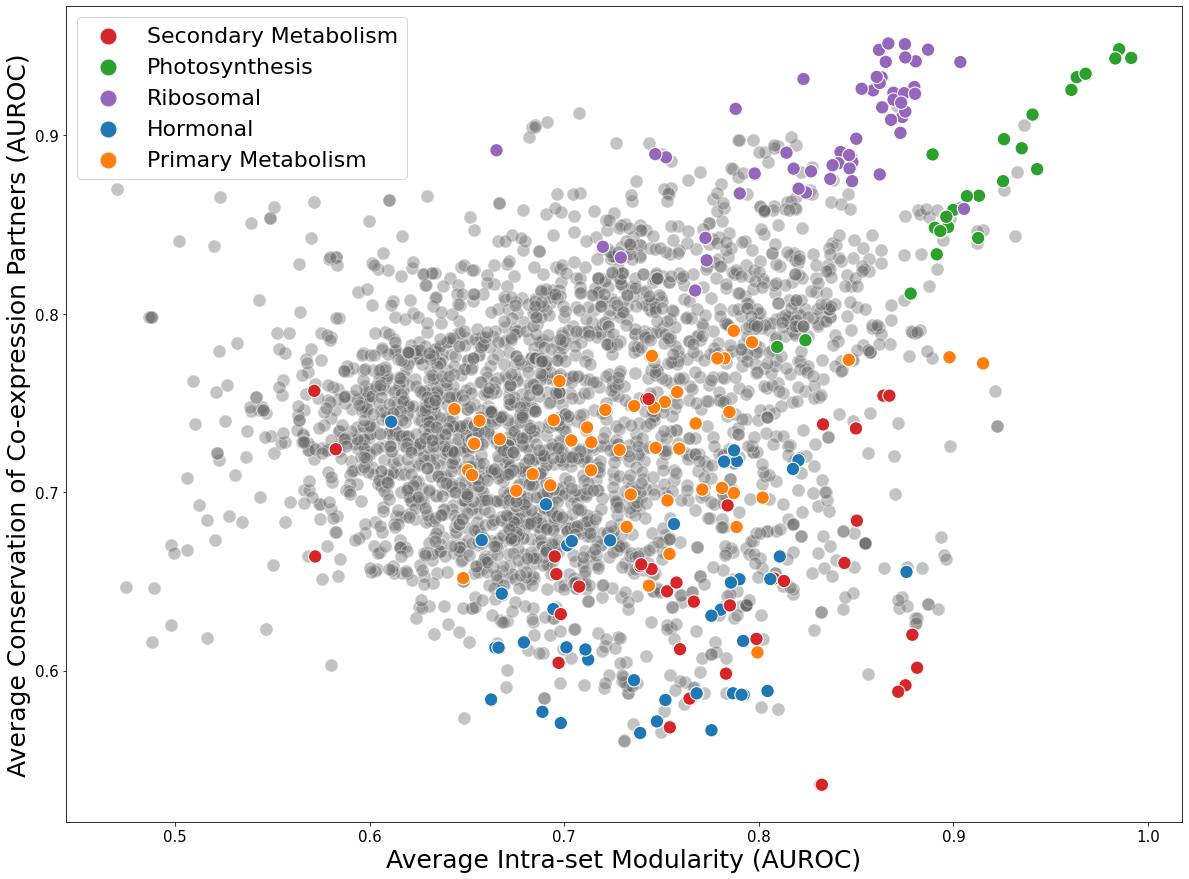

In [67]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = gm_version_of_full_annotated_group_list,y = 'Avg FC',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4)
sns.scatterplot(data = gm_all_annotated_groups_to_plot, x = 'Avg EGAD',y = 'Avg FC',s = 180, hue = 'Annotation', hue_order =['Secondary Metabolism','Photosynthesis','Ribosomal','Hormonal','Primary Metabolism'], palette = ['tab:red','tab:green','tab:purple','tab:blue', 'tab:orange'],)

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/poster_figure.jpg',dpi = 800)

[Text(0, 0, 'Background'),
 Text(1, 0, 'Ribosome'),
 Text(2, 0, 'Photosynthesis'),
 Text(3, 0, 'Primary Metabolism'),
 Text(4, 0, 'Secondary Metabolism')]

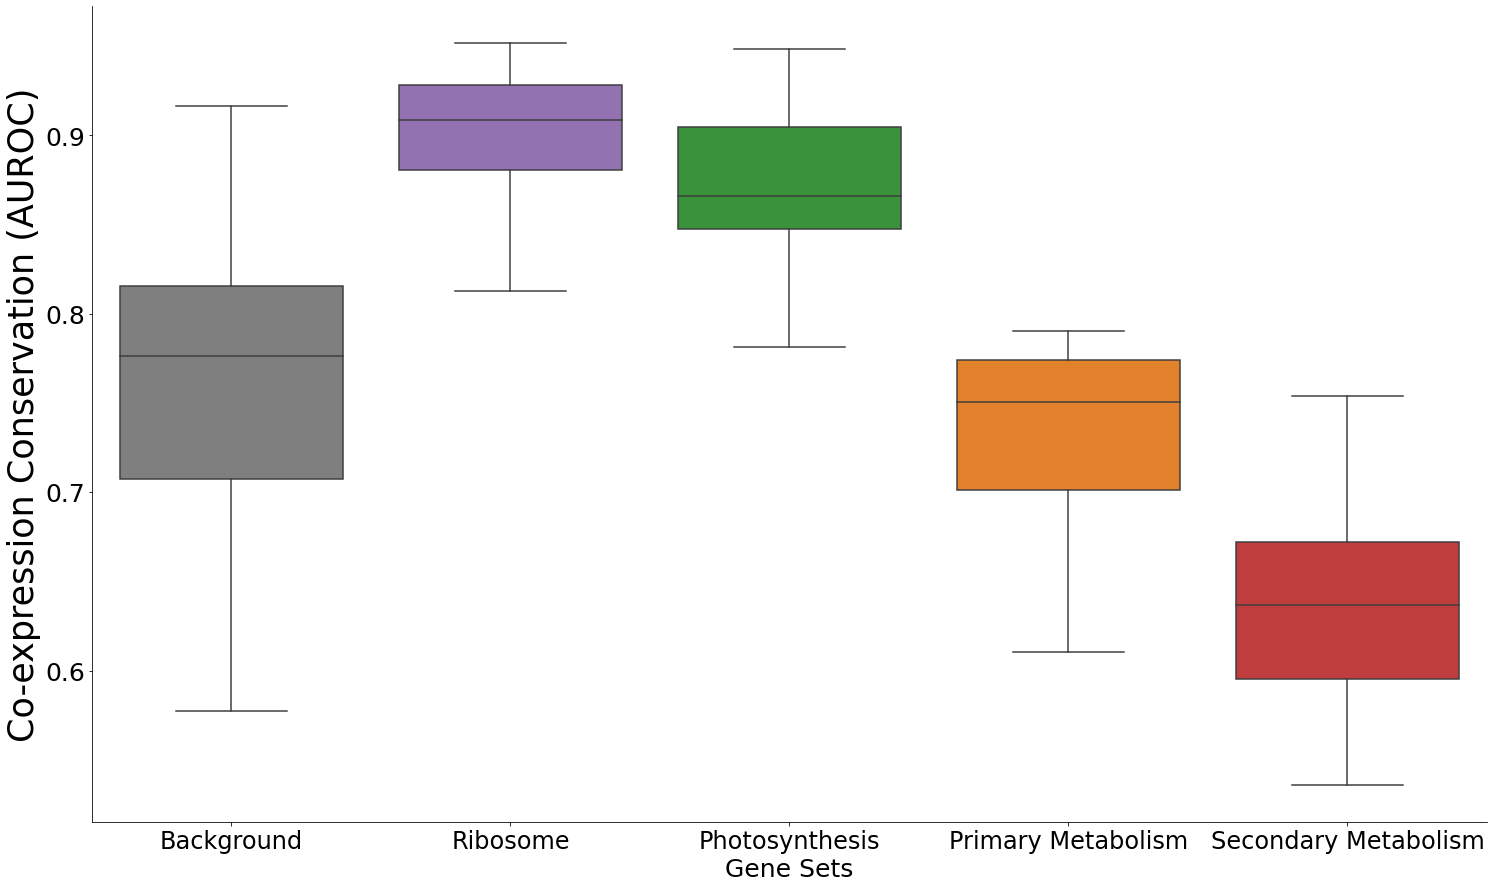

In [68]:
fig, ax = plt.subplots(figsize = (25,15))
sns.boxplot(data = gm_version_of_full_annotated_group_list.loc[gm_version_of_full_annotated_group_list['Avg EGAD']>.75], x = 'Annotation',y = 'Avg FC',order =['None','Ribosomal','Photosynthesis','Primary Metabolism','Secondary Metabolism'], palette = ['tab:gray','tab:purple','tab:green','tab:orange','tab:red', 'tab:orange'])
plt.ylabel("Co-expression Conservation (AUROC)", fontsize = 35)
plt.xlabel("Gene Sets", fontsize = 25)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 25)
ax.set_xticklabels(labels = ['Background','Ribosome','Photosynthesis','Primary Metabolism','Secondary Metabolism'])


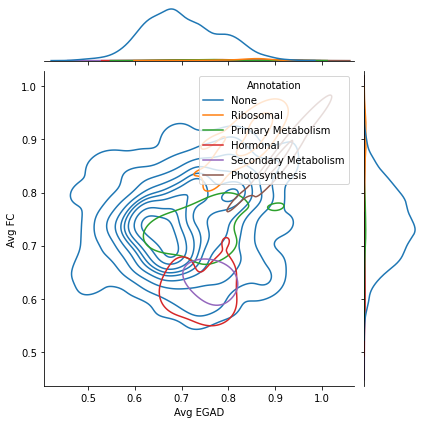

In [69]:
sns.jointplot(data =gm_version_of_full_annotated_group_list, x = 'Avg EGAD', y = 'Avg FC', hue = 'Annotation', kind = 'kde',  )

In [70]:
len(all_annotated_groups_to_plot.loc[(all_annotated_groups_to_plot['Annotation'] == 'Secondary Metabolism') & (all_annotated_groups_to_plot['Avg FC'] < .7) & (all_annotated_groups_to_plot['Avg EGAD'] > .7)])

26

In [71]:
ranked_and_filtered_scores  = filtered_groups_with_values.rank(numeric_only = True,method = 'first')
fc_ranked = ranked_and_filtered_scores['Avg FC'].to_list()
egad_ranked = ranked_and_filtered_scores['Avg EGAD'].to_list()
correlation,pvalue = stats.kendalltau(x = fc_ranked,y = egad_ranked,nan_policy = 'omit')
print(correlation)
print(pvalue)

0.1305653076232296
6.832269004338339e-27


In [72]:
sorted_values_for_windowing = filtered_groups_with_values.sort_values(by = 'Avg EGAD')
avg_fc_sorted_by_egad = sorted_values_for_windowing['Avg FC'].to_list()
avg_egad_sorted_by_egad = sorted_values_for_windowing['Avg EGAD'].to_list()
sorted_values_for_windowing.head()

Avg FC  Avg EGAD  \
GO:0030131  0.869822  0.470007   
GO:0008865  0.646671  0.474745   
GO:0035592  0.798047  0.486534   
GO:0071692  0.798047  0.487389   
GO:0002790  0.798047  0.487389   

                                                         Name  EGAD Counts  \
GO:0030131                           clathrin adaptor complex            5   
GO:0008865                              fructokinase activity            7   
GO:0035592  establishment of protein localization to extra...            8   
GO:0071692       protein localization to extracellular region            8   
GO:0002790                                  peptide secretion            8   

           Annotation  
GO:0030131       None  
GO:0008865       None  
GO:0035592       None  
GO:0071692       None  
GO:0002790       None

In [73]:
sorted_values_for_windowing

Avg FC  Avg EGAD  \
GO:0030131  0.869822  0.470007   
GO:0008865  0.646671  0.474745   
GO:0035592  0.798047  0.486534   
GO:0071692  0.798047  0.487389   
GO:0002790  0.798047  0.487389   
...              ...       ...   
GO:0009521  0.932681  0.963350   
GO:0009765  0.934619  0.967893   
GO:0016168  0.943177  0.983172   
GO:0009522  0.948384  0.985165   
GO:0009768  0.943499  0.991352   

                                                         Name  EGAD Counts  \
GO:0030131                           clathrin adaptor complex            5   
GO:0008865                              fructokinase activity            7   
GO:0035592  establishment of protein localization to extra...            8   
GO:0071692       protein localization to extracellular region            8   
GO:0002790                                  peptide secretion            8   
...                                                       ...          ...   
GO:0009521                                        photosystem           10   
GO:0009765                   photosynthesis, light harvesting           10   
GO:0016168                                chlorophyll binding           10   
GO:0009522                                      photosystem I           10   
GO:0009768  photosynthesis, light harvesting in photosystem I            9   

                Annotation  
GO:0030131            None  
GO:0008865            None  
GO:0035592            None  
GO:0071692            None  
GO:0002790            None  
...                    ...  
GO:0009521  Photosynthesis  
GO:0009765  Photosynthesis  
GO:0016168  Photosynthesis  
GO:0009522  Photosynthesis  
GO:0009768  Photosynthesis  

[3011 rows x 5 columns]

In [74]:
binned_sorted_values = sorted_values_for_windowing.copy()
binned_sorted_values['Modularity Range'] = 'Unbinned'
binned_sorted_values

Avg FC  Avg EGAD  \
GO:0030131  0.869822  0.470007   
GO:0008865  0.646671  0.474745   
GO:0035592  0.798047  0.486534   
GO:0071692  0.798047  0.487389   
GO:0002790  0.798047  0.487389   
...              ...       ...   
GO:0009521  0.932681  0.963350   
GO:0009765  0.934619  0.967893   
GO:0016168  0.943177  0.983172   
GO:0009522  0.948384  0.985165   
GO:0009768  0.943499  0.991352   

                                                         Name  EGAD Counts  \
GO:0030131                           clathrin adaptor complex            5   
GO:0008865                              fructokinase activity            7   
GO:0035592  establishment of protein localization to extra...            8   
GO:0071692       protein localization to extracellular region            8   
GO:0002790                                  peptide secretion            8   
...                                                       ...          ...   
GO:0009521                                        photosystem           10   
GO:0009765                   photosynthesis, light harvesting           10   
GO:0016168                                chlorophyll binding           10   
GO:0009522                                      photosystem I           10   
GO:0009768  photosynthesis, light harvesting in photosystem I            9   

                Annotation Modularity Range  
GO:0030131            None         Unbinned  
GO:0008865            None         Unbinned  
GO:0035592            None         Unbinned  
GO:0071692            None         Unbinned  
GO:0002790            None         Unbinned  
...                    ...              ...  
GO:0009521  Photosynthesis         Unbinned  
GO:0009765  Photosynthesis         Unbinned  
GO:0016168  Photosynthesis         Unbinned  
GO:0009522  Photosynthesis         Unbinned  
GO:0009768  Photosynthesis         Unbinned  

[3011 rows x 6 columns]

In [75]:
orderer = ['0.5 - 0.55','0.55 - 0.6','0.6 - 0.65','0.65 - 0.7','0.7 - 0.75','0.75 - 0.8','0.8 - 0.85','0.85 - 0.9','0.9 - 0.95','0.95 - 1']

In [76]:
binned_sorted_values['Modularity Range'].loc[binned_sorted_values['Avg EGAD']<=.50] = '0.45 - 0.5'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.5) & (binned_sorted_values['Avg EGAD']<=.55)] = '0.5 - 0.55'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.55) & (binned_sorted_values['Avg EGAD']<=.6)] = '0.55 - 0.6'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.6) & (binned_sorted_values['Avg EGAD']<=.65)] = '0.6 - 0.65'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.65) & (binned_sorted_values['Avg EGAD']<=.7)] = '0.65 - 0.7'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.7) & (binned_sorted_values['Avg EGAD']<=.75)] = '0.7 - 0.75'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.75) & (binned_sorted_values['Avg EGAD']<=.8)] = '0.75 - 0.8'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.8) & (binned_sorted_values['Avg EGAD']<=.85)] = '0.8 - 0.85'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.85) & (binned_sorted_values['Avg EGAD']<=.9)] = '0.85 - 0.9'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.9) & (binned_sorted_values['Avg EGAD']<=.95)] = '0.9 - 0.95'
binned_sorted_values['Modularity Range'].loc[(binned_sorted_values['Avg EGAD']>.95)] = '0.95 - 1'

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

In [77]:
binned_sorted_values

Avg FC  Avg EGAD  \
GO:0030131  0.869822  0.470007   
GO:0008865  0.646671  0.474745   
GO:0035592  0.798047  0.486534   
GO:0071692  0.798047  0.487389   
GO:0002790  0.798047  0.487389   
...              ...       ...   
GO:0009521  0.932681  0.963350   
GO:0009765  0.934619  0.967893   
GO:0016168  0.943177  0.983172   
GO:0009522  0.948384  0.985165   
GO:0009768  0.943499  0.991352   

                                                         Name  EGAD Counts  \
GO:0030131                           clathrin adaptor complex            5   
GO:0008865                              fructokinase activity            7   
GO:0035592  establishment of protein localization to extra...            8   
GO:0071692       protein localization to extracellular region            8   
GO:0002790                                  peptide secretion            8   
...                                                       ...          ...   
GO:0009521                                        photosystem           10   
GO:0009765                   photosynthesis, light harvesting           10   
GO:0016168                                chlorophyll binding           10   
GO:0009522                                      photosystem I           10   
GO:0009768  photosynthesis, light harvesting in photosystem I            9   

                Annotation Modularity Range  
GO:0030131            None       0.45 - 0.5  
GO:0008865            None       0.45 - 0.5  
GO:0035592            None       0.45 - 0.5  
GO:0071692            None       0.45 - 0.5  
GO:0002790            None       0.45 - 0.5  
...                    ...              ...  
GO:0009521  Photosynthesis         0.95 - 1  
GO:0009765  Photosynthesis         0.95 - 1  
GO:0016168  Photosynthesis         0.95 - 1  
GO:0009522  Photosynthesis         0.95 - 1  
GO:0009768  Photosynthesis         0.95 - 1  

[3011 rows x 6 columns]

In [78]:
binned_sorted_values['Decile'] = pd.qcut(binned_sorted_values['Avg EGAD'], q = 10, labels = False)
binned_sorted_values['Decile'] = binned_sorted_values['Decile'] +1

In [79]:
binned_sorted_values

Avg FC  Avg EGAD  \
GO:0030131  0.869822  0.470007   
GO:0008865  0.646671  0.474745   
GO:0035592  0.798047  0.486534   
GO:0071692  0.798047  0.487389   
GO:0002790  0.798047  0.487389   
...              ...       ...   
GO:0009521  0.932681  0.963350   
GO:0009765  0.934619  0.967893   
GO:0016168  0.943177  0.983172   
GO:0009522  0.948384  0.985165   
GO:0009768  0.943499  0.991352   

                                                         Name  EGAD Counts  \
GO:0030131                           clathrin adaptor complex            5   
GO:0008865                              fructokinase activity            7   
GO:0035592  establishment of protein localization to extra...            8   
GO:0071692       protein localization to extracellular region            8   
GO:0002790                                  peptide secretion            8   
...                                                       ...          ...   
GO:0009521                                        photosystem           10   
GO:0009765                   photosynthesis, light harvesting           10   
GO:0016168                                chlorophyll binding           10   
GO:0009522                                      photosystem I           10   
GO:0009768  photosynthesis, light harvesting in photosystem I            9   

                Annotation Modularity Range  Decile  
GO:0030131            None       0.45 - 0.5       1  
GO:0008865            None       0.45 - 0.5       1  
GO:0035592            None       0.45 - 0.5       1  
GO:0071692            None       0.45 - 0.5       1  
GO:0002790            None       0.45 - 0.5       1  
...                    ...              ...     ...  
GO:0009521  Photosynthesis         0.95 - 1      10  
GO:0009765  Photosynthesis         0.95 - 1      10  
GO:0016168  Photosynthesis         0.95 - 1      10  
GO:0009522  Photosynthesis         0.95 - 1      10  
GO:0009768  Photosynthesis         0.95 - 1      10  

[3011 rows x 7 columns]

(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

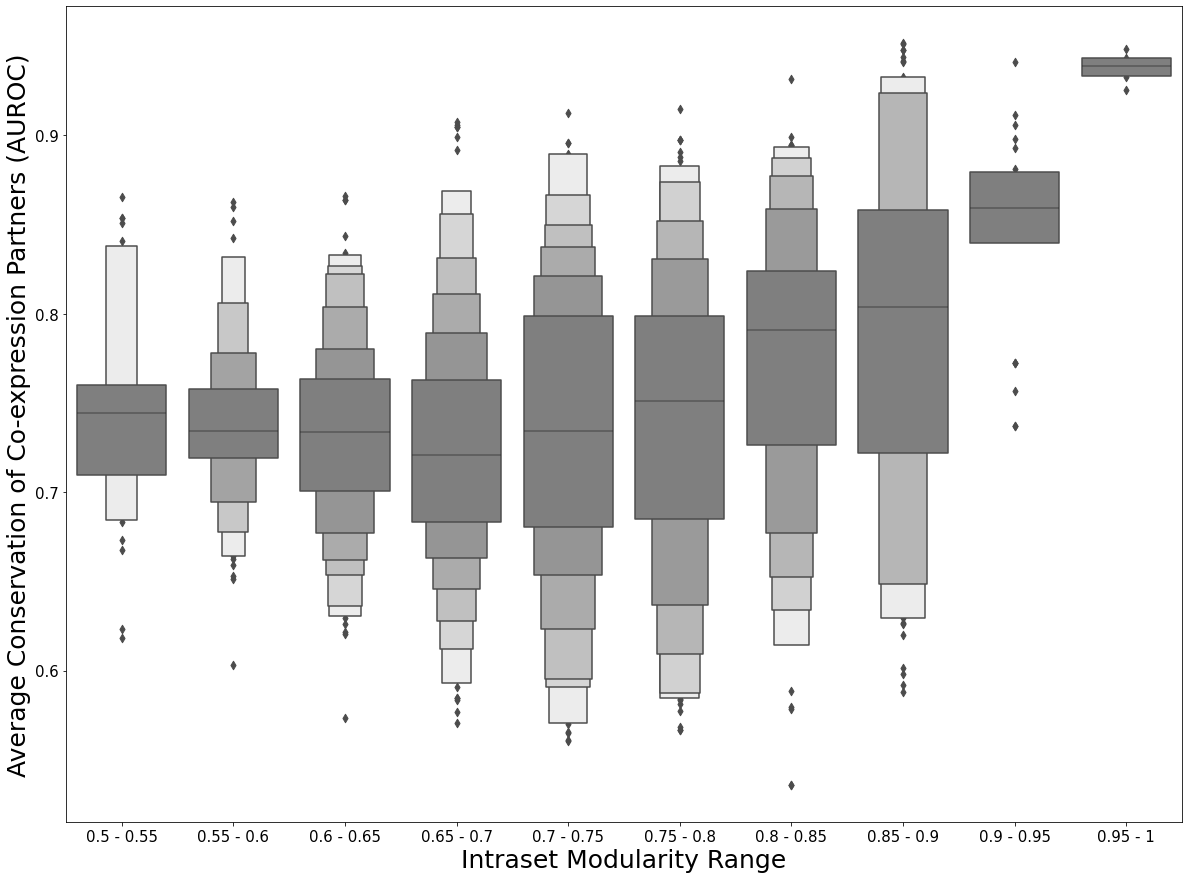

In [80]:
fig, ax = plt.subplots(figsize = (20,15))

sns.boxenplot(data = binned_sorted_values, x = 'Modularity Range',y = 'Avg FC', color = 'tab:gray', scale = 'area', order = orderer)
plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Intraset Modularity Range", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

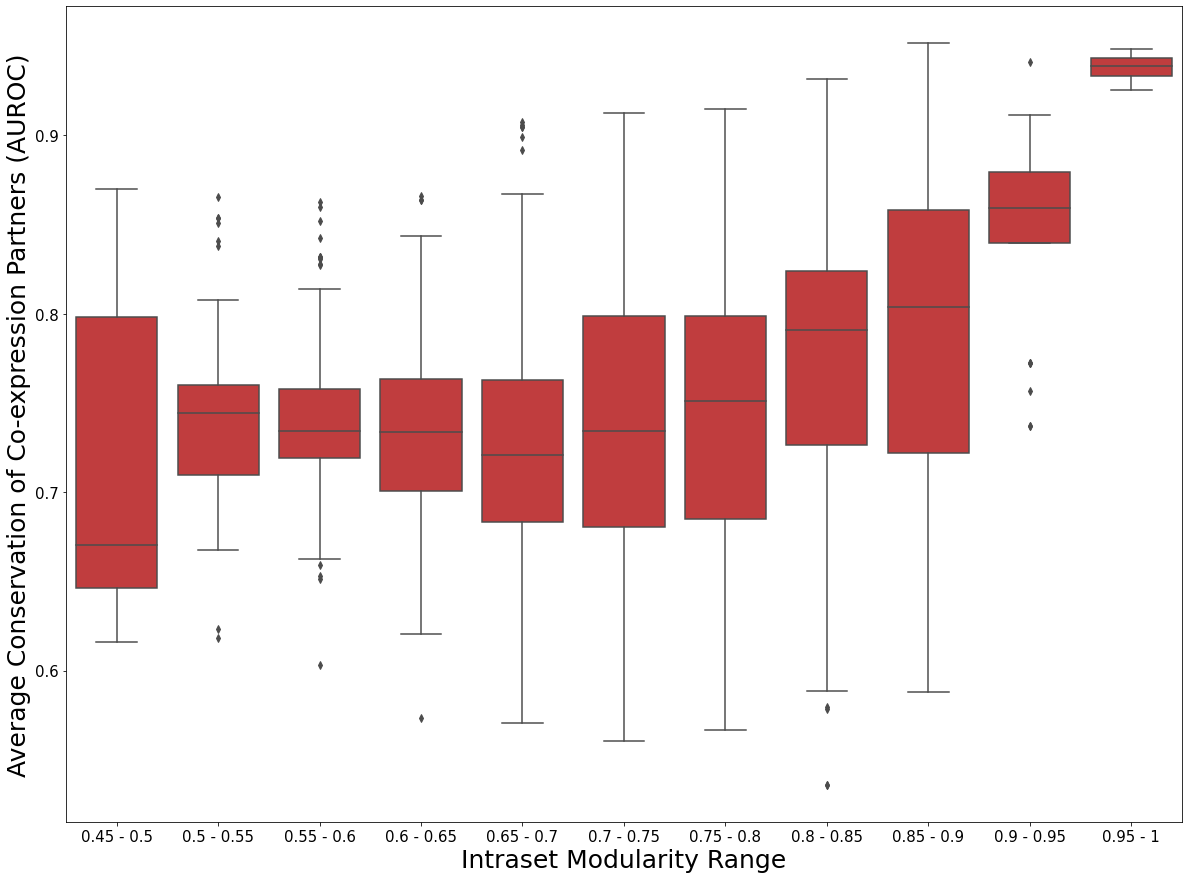

In [81]:
fig, ax = plt.subplots(figsize = (20,15))

sns.boxplot(data = binned_sorted_values, x = 'Modularity Range',y = 'Avg FC', color = 'tab:red')
plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Intraset Modularity Range", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

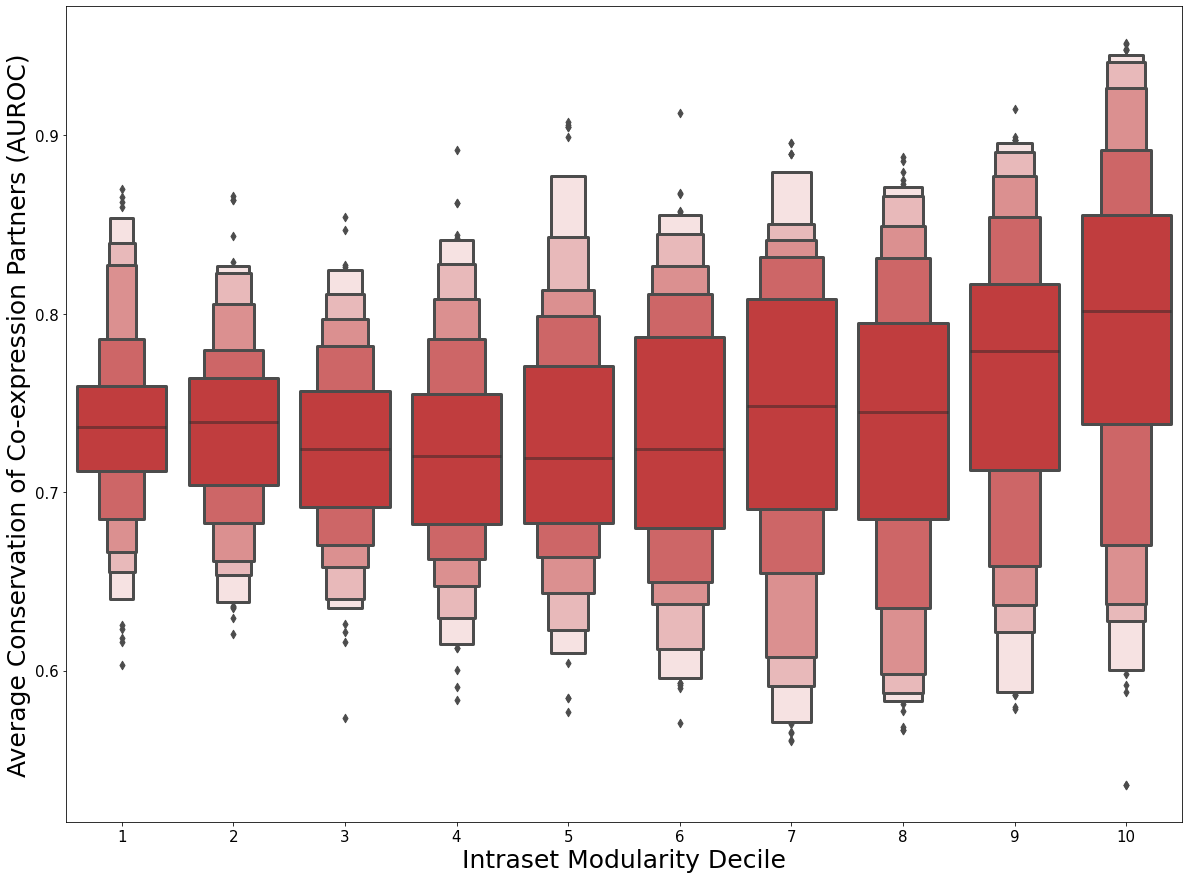

In [82]:
fig, ax = plt.subplots(figsize = (20,15))
sns.boxenplot(data = binned_sorted_values, x = 'Decile',y = 'Avg FC', color = 'tab:red', scale = 'area', linewidth = 3)
plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Intraset Modularity Decile", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

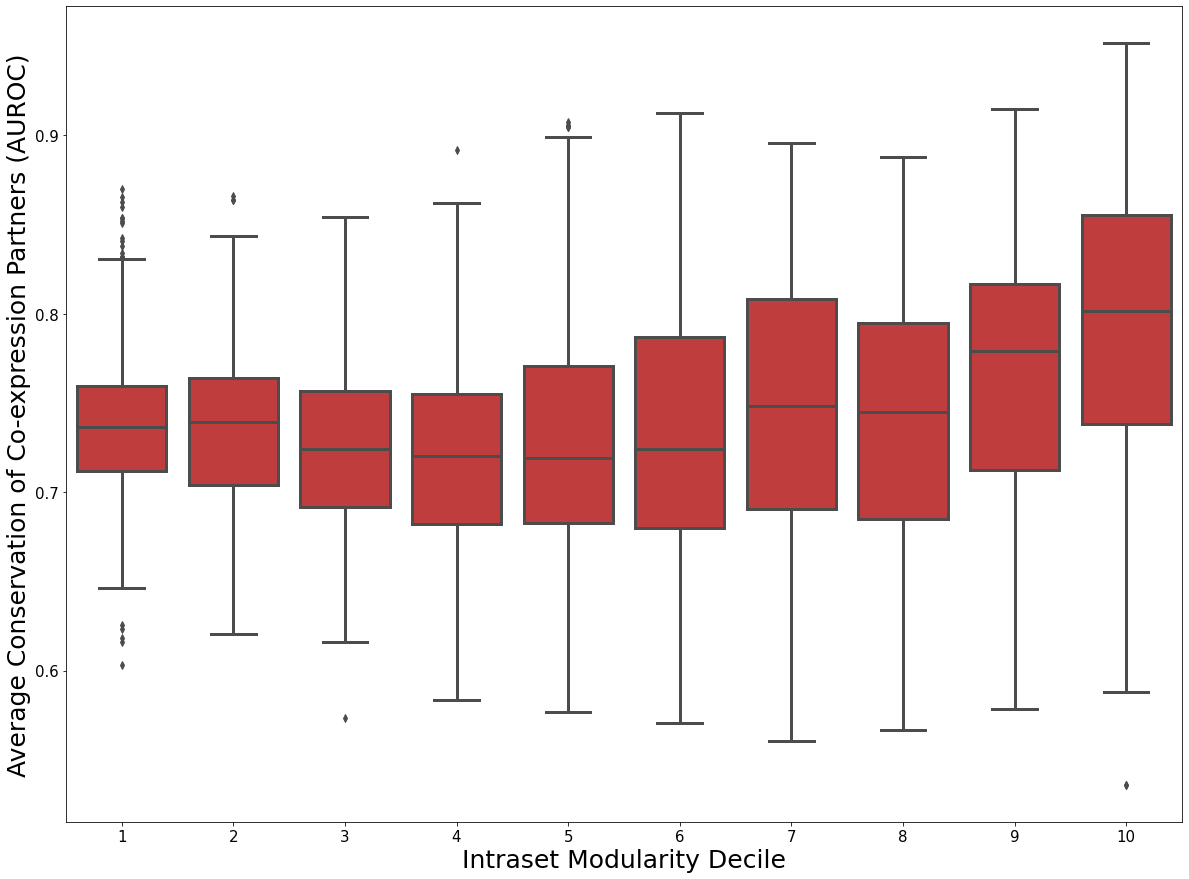

In [83]:
fig, ax = plt.subplots(figsize = (20,15))
sns.boxplot(data = binned_sorted_values, x = 'Decile',y = 'Avg FC', color = 'tab:red', linewidth = 3)
plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Intraset Modularity Decile", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [84]:
sliding_var_avg_fc = bn.move.move_var(a = avg_fc_sorted_by_egad, window = 50)
sliding_mean_egad = bn.move.move_mean(a = avg_egad_sorted_by_egad,window = 50)
len(sliding_mean_egad)

3011

In [85]:
window_size_list = [10,20,30,40,50,60,70,80,100]

<function seaborn.rcmod.reset_orig()>

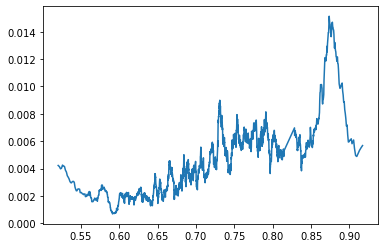

In [86]:
sns.lineplot(x = sliding_mean_egad, y = sliding_var_avg_fc)
sns.reset_orig

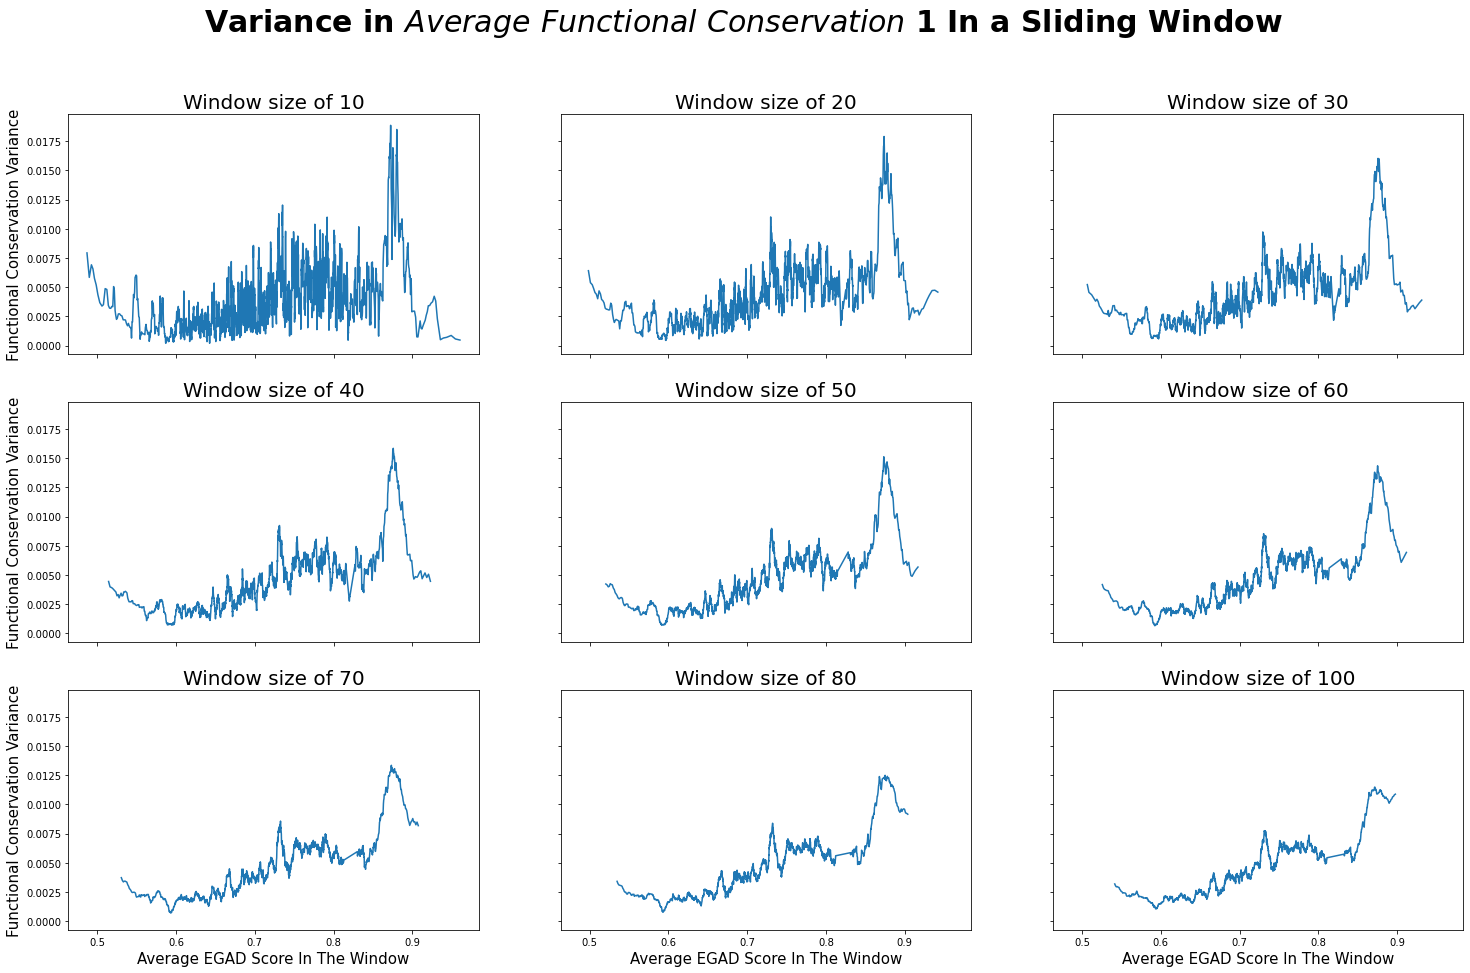

In [87]:
#fig, axs = plt.subplots(3,2,figsize = (15,15))
fig, axs = plt.subplots(3,3,sharex = True, sharey = True,figsize = (25,15))
fig.suptitle('Variance in $Average$ $Functional$ $Conservation$ 1 In a Sliding Window',fontsize = 30,fontweight = 'bold')
for (ax_number,value) in zip(axs.flat,window_size_list): 
    current_var = bn.move.move_var(a = avg_fc_sorted_by_egad, window = value)
    current_mean = bn.move.move_mean(a = avg_egad_sorted_by_egad,window = value)
    sns.lineplot(ax = ax_number,x = current_mean, y = current_var)
    ax_number.set_xlabel('Average EGAD Score In The Window',fontsize = 15)
    ax_number.set_ylabel('Functional Conservation Variance',fontsize = 15)
    ax_number.set_title('Window size of {}'.format(value), fontsize = 20)
    #ax_number.plot(current_mean,current_var)

In [88]:
non_zero_groups_egad = groups_with_values.loc[groups_with_values['EGAD Counts']>0]

Text(0.5, 1.0, 'Bimodality in number of species with GO group- tendancy towards all or 1')

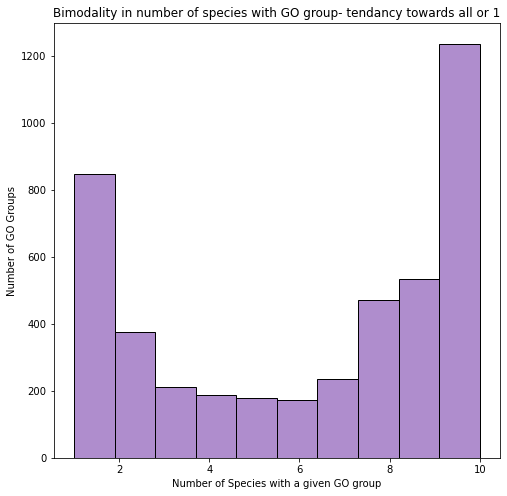

In [89]:
fig, ax = plt.subplots(figsize = (8,8))
sns.histplot(data = non_zero_groups_egad,x = 'EGAD Counts',bins = 10, color = 'tab:purple')
plt.xlabel("Number of Species with a given GO group")
plt.ylabel("Number of GO Groups")
plt.title("Bimodality in number of species with GO group- tendancy towards all or 1")

In [90]:
#### Next do size of go groups 

In [91]:
all_go_terms.loc['GO:0016165']

Name           linoleate 13S-lipoxygenase activity
grape                                          NaN
arabidopsis                                    NaN
mustard                                        NaN
soybean                                        NaN
medicago                                  0.525607
tomato                                         NaN
potato                                         NaN
rice                                           NaN
brome                                          NaN
sorghum                                        NaN
maize                                          NaN
Name: GO:0016165, dtype: object

In [92]:
### Tmrrw Need to rewrite the get Fc_sc to work with any two species- will be a nightmare lol need to map every pair combo - do as a matrix
# Add brome to maps
mapped_csv = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_gene_ortholog_files.csv',index_col = 0)
#mapped_csv = mapped_csv.replace(to_replace = 'None',value = np.nan)


In [93]:
mapped_csv.loc['Arabidopsis thaliana','Sorghum bicolor']

'/data/CoCoCoNet/orthologMaps/arabidopsis_sorghum_orthoNM.csv'

In [94]:
test_1 = 'Arabidopsis thaliana'
test_2 = 'Sorghum bicolor'

In [95]:
mapped_csv.loc[test_1,test_2]

'/data/CoCoCoNet/orthologMaps/arabidopsis_sorghum_orthoNM.csv'

In [96]:
just_go_terms_and_names = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/go_terms.txt',sep = '\t')
go_terms_with_counts_in_each_species = just_go_terms_and_names.copy(deep = True)
for species in coconet_plants:
    print(species)
    current_species_annotations = get_go_annotations_as_panda(species)
    go_groups_with_counts = pd.DataFrame(current_species_annotations.sum(axis = 0),columns = ['{} Count'.format(species)])
    go_terms_with_counts_in_each_species = go_terms_with_counts_in_each_species.merge(right = go_groups_with_counts,left_index = True, right_index = True,how = 'left')
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     for current_go_term in go_groups_with_counts.index.to_list():
#         current_go_term_list_of_fc_scores = []
#         genes_in_go_term = current_species_annotations.loc[current_species_annotations[current_go_term]==1].index
#         genes_in_go_term = pd.DataFrame(data =list(genes_in_go_term),columns = ['Genes'])
#         for current_combination in combos_that_start_with_species:
#             current_fc_map =get_fc_sc_btw_two_species_with_gene_list(current_combination[0],current_combination[1],genes_in_go_term)
#             mean_fc = current_fc_map.mean()[0]
#             current_go_term_list_of_fc_scores.append(mean_fc)
#         mean_across_species = statistics.mean(current_go_term_list_of_fc_scores)
#         all_go_terms.loc[current_go_term,species] = mean_across_species


grape
arabidopsis
soybean
medicago
tomato
potato
rice
brome
sorghum
maize


In [97]:
go_term_averages = pd.DataFrame(go_terms_with_counts_in_each_species.mean(axis = 1),columns = ['AVG Family Members'] )
groups_with_values_and_avg_num_genes_in_group = groups_with_values.merge(right = go_term_averages,left_index = True, right_index = True, how = 'left')
groups_with_values_and_avg_num_genes_in_group

Avg FC  Avg EGAD  \
GO:0000001       NaN       NaN   
GO:0000002       NaN       NaN   
GO:0000003  0.740324  0.634227   
GO:0000006       NaN       NaN   
GO:0000007       NaN       NaN   
...              ...       ...   
GO:0051184  0.746524  0.598399   
GO:0051194  0.815936  0.739692   
GO:0051182  0.744765  0.607253   
GO:0051185  0.749290  0.614238   
GO:0018065  0.716085  0.771988   

                                                         Name  EGAD Counts  \
GO:0000001                          mitochondrion inheritance            0   
GO:0000002                   mitochondrial genome maintenance            0   
GO:0000003                                       reproduction           10   
GO:0000006  high-affinity zinc transmembrane transporter a...            0   
GO:0000007  low-affinity zinc ion transmembrane transporte...            0   
...                                                       ...          ...   
GO:0051184                                                NaN            5   
GO:0051194                                                NaN            1   
GO:0051182                                                NaN            5   
GO:0051185                                                NaN            5   
GO:0018065                                                NaN            1   

            AVG Family Members  
GO:0000001                 NaN  
GO:0000002            2.666667  
GO:0000003          620.700000  
GO:0000006                 NaN  
GO:0000007                 NaN  
...                        ...  
GO:0051184                 NaN  
GO:0051194                 NaN  
GO:0051182                 NaN  
GO:0051185                 NaN  
GO:0018065                 NaN  

[44290 rows x 5 columns]

In [98]:
groups_with_values_and_avg_num_genes_in_group['Average Genes In Group'] = np.nan 
groups_with_values_and_avg_num_genes_in_group['Average Genes In Group'].loc[(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']>0) &(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']<9)] = '0-8'
groups_with_values_and_avg_num_genes_in_group['Average Genes In Group'].loc[(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']>8) &(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']<20)] = '9-20'
groups_with_values_and_avg_num_genes_in_group['Average Genes In Group'].loc[(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']>20) &(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']<40)] = '20-40'
groups_with_values_and_avg_num_genes_in_group['Average Genes In Group'].loc[(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']>40) &(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']<80)] = '40-80'
groups_with_values_and_avg_num_genes_in_group['Average Genes In Group'].loc[(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']>80) &(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']<200)] = '80-200'
groups_with_values_and_avg_num_genes_in_group['Average Genes In Group'].loc[(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']>200) &(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']<500)] = '200-500'
groups_with_values_and_avg_num_genes_in_group['Average Genes In Group'].loc[(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']>500) &(groups_with_values_and_avg_num_genes_in_group['AVG Family Members']<10000)] = '500+'

groups_with_values_and_avg_num_genes_in_group

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

Avg FC  Avg EGAD  \
GO:0000001       NaN       NaN   
GO:0000002       NaN       NaN   
GO:0000003  0.740324  0.634227   
GO:0000006       NaN       NaN   
GO:0000007       NaN       NaN   
...              ...       ...   
GO:0051184  0.746524  0.598399   
GO:0051194  0.815936  0.739692   
GO:0051182  0.744765  0.607253   
GO:0051185  0.749290  0.614238   
GO:0018065  0.716085  0.771988   

                                                         Name  EGAD Counts  \
GO:0000001                          mitochondrion inheritance            0   
GO:0000002                   mitochondrial genome maintenance            0   
GO:0000003                                       reproduction           10   
GO:0000006  high-affinity zinc transmembrane transporter a...            0   
GO:0000007  low-affinity zinc ion transmembrane transporte...            0   
...                                                       ...          ...   
GO:0051184                                                NaN            5   
GO:0051194                                                NaN            1   
GO:0051182                                                NaN            5   
GO:0051185                                                NaN            5   
GO:0018065                                                NaN            1   

            AVG Family Members Average Genes In Group  
GO:0000001                 NaN                    NaN  
GO:0000002            2.666667                    0-8  
GO:0000003          620.700000                   500+  
GO:0000006                 NaN                    NaN  
GO:0000007                 NaN                    NaN  
...                        ...                    ...  
GO:0051184                 NaN                    NaN  
GO:0051194                 NaN                    NaN  
GO:0051182                 NaN                    NaN  
GO:0051185                 NaN                    NaN  
GO:0018065                 NaN                    NaN  

[44290 rows x 6 columns]

In [99]:
groups_with_values_and_avg_num_genes_in_group
groups_with_values_and_avg_num_genes_in_group.loc[groups_with_values_and_avg_num_genes_in_group['EGAD Counts']>3]

Avg FC  Avg EGAD                              Name  EGAD Counts  \
GO:0000003  0.740324  0.634227                      reproduction           10   
GO:0000018  0.766573  0.798689   regulation of DNA recombination            8   
GO:0000027  0.923946  0.869159  ribosomal large subunit assembly            9   
GO:0000028  0.951180  0.875073  ribosomal small subunit assembly            9   
GO:0000030  0.714718  0.642678      mannosyltransferase activity            8   
...              ...       ...                               ...          ...   
GO:0051181  0.732571  0.655892                               NaN            8   
GO:0051193  0.734276  0.660798                               NaN            4   
GO:0051184  0.746524  0.598399                               NaN            5   
GO:0051182  0.744765  0.607253                               NaN            5   
GO:0051185  0.749290  0.614238                               NaN            5   

            AVG Family Members Average Genes In Group  
GO:0000003               620.7                   500+  
GO:0000018                22.2                  20-40  
GO:0000027                44.4                  40-80  
GO:0000028                28.5                  20-40  
GO:0000030                27.2                  20-40  
...                        ...                    ...  
GO:0051181                 NaN                    NaN  
GO:0051193                 NaN                    NaN  
GO:0051184                 NaN                    NaN  
GO:0051182                 NaN                    NaN  
GO:0051185                 NaN                    NaN  

[3011 rows x 6 columns]

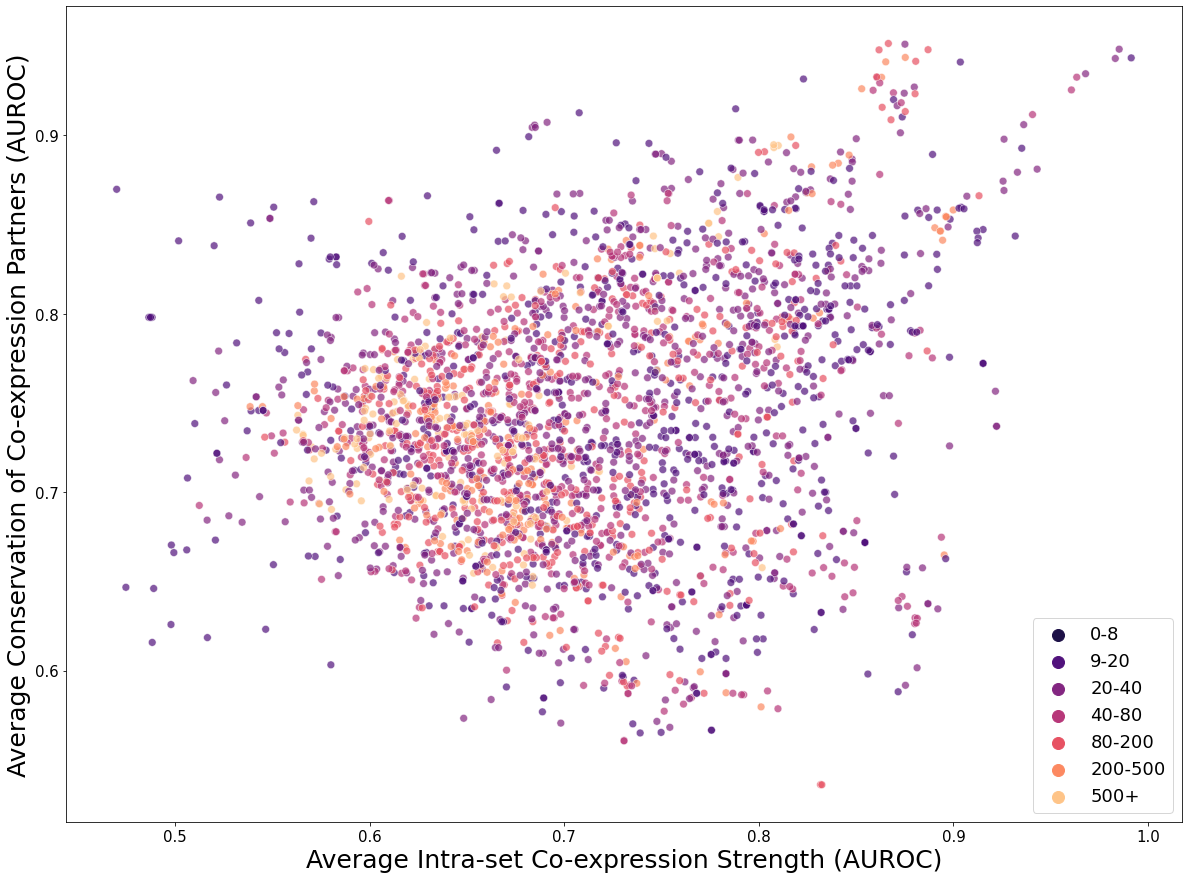

In [100]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = groups_with_values_and_avg_num_genes_in_group.loc[groups_with_values_and_avg_num_genes_in_group['EGAD Counts']>3],y = 'Avg FC',x = 'Avg EGAD',s = 60, hue = 'Average Genes In Group',palette = 'magma',hue_order = ['0-8','9-20','20-40','40-80','80-200','200-500','500+'],alpha = .7)
#scatter = ax.scatter(x = groups_with_values_and_avg_num_genes_in_group['Avg FC'],y = groups_with_values_and_avg_num_genes_in_group['Avg EGAD'],c = groups_with_values_and_avg_num_genes_in_group['AVG Family Members'],vmin = 1, vmax = 100)
#handles, labels = scatter.legend_elements(prop = 'colors', alpha = .8,)
#legend2 = ax.legend(handles,labels,loc = 'lower left', title = 'Number of genes in Family')
plt.legend(fontsize= 18,markerscale = 2)
plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Co-expression Strength (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [101]:
filtered_groups_with_values = groups_with_values.loc[groups_with_values['EGAD Counts']>4]
filtered_groups_with_values

Avg FC  Avg EGAD                              Name  EGAD Counts
GO:0000003  0.740324  0.634227                      reproduction           10
GO:0000018  0.766573  0.798689   regulation of DNA recombination            8
GO:0000027  0.923946  0.869159  ribosomal large subunit assembly            9
GO:0000028  0.951180  0.875073  ribosomal small subunit assembly            9
GO:0000030  0.714718  0.642678      mannosyltransferase activity            8
...              ...       ...                               ...          ...
GO:0006733  0.724414  0.715443                               NaN            9
GO:0051181  0.732571  0.655892                               NaN            8
GO:0051184  0.746524  0.598399                               NaN            5
GO:0051182  0.744765  0.607253                               NaN            5
GO:0051185  0.749290  0.614238                               NaN            5

[2824 rows x 4 columns]

In [102]:
groups_with_values

Avg FC  Avg EGAD  \
GO:0000001       NaN       NaN   
GO:0000002       NaN       NaN   
GO:0000003  0.740324  0.634227   
GO:0000006       NaN       NaN   
GO:0000007       NaN       NaN   
...              ...       ...   
GO:0051184  0.746524  0.598399   
GO:0051194  0.815936  0.739692   
GO:0051182  0.744765  0.607253   
GO:0051185  0.749290  0.614238   
GO:0018065  0.716085  0.771988   

                                                         Name  EGAD Counts  
GO:0000001                          mitochondrion inheritance            0  
GO:0000002                   mitochondrial genome maintenance            0  
GO:0000003                                       reproduction           10  
GO:0000006  high-affinity zinc transmembrane transporter a...            0  
GO:0000007  low-affinity zinc ion transmembrane transporte...            0  
...                                                       ...          ...  
GO:0051184                                                NaN            5  
GO:0051194                                                NaN            1  
GO:0051182                                                NaN            5  
GO:0051185                                                NaN            5  
GO:0018065                                                NaN            1  

[44290 rows x 4 columns]

In [103]:
made_up_groups = get_go_annotations_as_panda('grape')

In [104]:
### Take original program, fill random values into groups
made_up_groups.shape[0]

16462

In [105]:
def create_fake_go_groups(real_go_panda):
    panda_size = real_go_panda.shape
    panda_filler = np.random.binomial(n = 1,p = 16/panda_size[0],size = panda_size)
    fake_groups = pd.DataFrame(data = panda_filler,columns = real_go_panda.columns,index = real_go_panda.index)
    return fake_groups

In [106]:
faked_data = create_fake_go_groups(made_up_groups)

In [107]:
faked_data.sum()

GO_term
GO:0000002    11
GO:0000003    17
GO:0000009    10
GO:0000012    13
GO:0000014    13
              ..
GO:2001257    18
GO:2001289    10
GO:2001293    17
GO:2001294    11
GO:2001295    13
Length: 8293, dtype: int64

In [108]:
fake_go_terms = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/go_terms.txt',sep = '\t')
fake_go_terms[['grape','arabidopsis','mustard','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']] = np.nan
fake_go_terms

Name  grape  \
GO:0000001                          mitochondrion inheritance    NaN   
GO:0000002                   mitochondrial genome maintenance    NaN   
GO:0000003                                       reproduction    NaN   
GO:0000006  high-affinity zinc transmembrane transporter a...    NaN   
GO:0000007  low-affinity zinc ion transmembrane transporte...    NaN   
...                                                       ...    ...   
GO:2001313  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...    NaN   
GO:2001314  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...    NaN   
GO:2001315  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...    NaN   
GO:2001316                       kojic acid metabolic process    NaN   
GO:2001317                    kojic acid biosynthetic process    NaN   

            arabidopsis  mustard  soybean  medicago  tomato  potato  rice  \
GO:0000001          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000002          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000003          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000006          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:0000007          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
...                 ...      ...      ...       ...     ...     ...   ...   
GO:2001313          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001314          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001315          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001316          NaN      NaN      NaN       NaN     NaN     NaN   NaN   
GO:2001317          NaN      NaN      NaN       NaN     NaN     NaN   NaN   

            brome  sorghum  maize  
GO:0000001    NaN      NaN    NaN  
GO:0000002    NaN      NaN    NaN  
GO:0000003    NaN      NaN    NaN  
GO:0000006    NaN      NaN    NaN  
GO:0000007    NaN      NaN    NaN  
...           ...      ...    ...  
GO:2001313    NaN      NaN    NaN  
GO:2001314    NaN      NaN    NaN  
GO:2001315    NaN      NaN    NaN  
GO:2001316    NaN      NaN    NaN  
GO:2001317    NaN      NaN    NaN  

[44272 rows x 12 columns]

In [109]:
# np.random.seed(10)
# for species in coconet_plants:
#     print(species)
#     combos_that_start_with_species = []
#     for combo in plant_combinations:
#         if combo[0] == species:
#             combos_that_start_with_species.append(combo)
#     current_species_annotations = get_go_annotations_as_panda(species)
#     current_species_annotations = create_fake_go_groups(current_species_annotations)
#     go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     for current_go_term in go_groups_with_counts.index.to_list():
#         current_go_term_list_of_fc_scores = []
#         genes_in_go_term = current_species_annotations.loc[current_species_annotations[current_go_term]==1].index
#         genes_in_go_term = pd.DataFrame(data =list(genes_in_go_term),columns = ['Genes'])
#         for current_combination in combos_that_start_with_species:
#             current_fc_map =get_fc_sc_btw_two_species_with_gene_list(current_combination[0],current_combination[1],genes_in_go_term)
#             mean_fc = current_fc_map.mean()[0]
#             current_go_term_list_of_fc_scores.append(mean_fc)
#         mean_across_species = statistics.mean(current_go_term_list_of_fc_scores)
#         fake_go_terms.loc[current_go_term,species] = mean_across_species


In [110]:
#  fake_go_terms.to_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/fake_go_term_fc_results.csv')


In [111]:
# cococonet_map = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/All_CoCoCoNet_Paths.csv')
# fake_egad_results = pd.DataFrame(index = all_go_terms.index)
# np.random.seed(10)
# for species in coconet_plants:
#     print(species)
#     combos_that_start_with_species = []
#     current_species_path_cococonet = cococonet_map['Path'].loc[cococonet_map['Common Name'] == species].item()
#     for combo in plant_combinations:
#         if combo[0] == species:
#             combos_that_start_with_species.append(combo)
#     current_species_annotations = get_go_annotations_as_panda(species)
#     current_species_annotations = create_fake_go_groups(current_species_annotations)

#     go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     go_groups_for_egad = go_groups_with_counts.index.to_list()
#     annotations_to_run_egad_on = current_species_annotations[go_groups_for_egad]
#     current_scientific_name = species_name_resolver(species_1 = species,desired_type = 'scientific') 
#     current_cococonet = read_cococonet(current_species_path_cococonet)
#     egad_results = run_egad(go = annotations_to_run_egad_on, nw = current_cococonet,min_count =10, max_count = 2000 )
#     fake_egad_results = fake_egad_results.merge(right = egad_results[['AUC','P_Value']], how = 'left', left_index= True,right_index= True)
#     fake_egad_results = fake_egad_results.rename(columns = {'AUC':'{} AUC'.format(species),'P_Value':'{} P_Value'.format(species)})

In [112]:
#  fake_egad_results.to_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/fake_egad_results.csv')

In [113]:
def get_ortholog_map(species_1,species_2):
    """[summary]

    Args:
        species_1 ([type]): [description]
        species_2 ([type]): [description]

    Returns:
        [type]: [description]
    """
    import Name_resolver as nr
    import pandas as pd
    species_1 = nr.species_name_resolver(species_1,'scientific')
    species_2 = nr.species_name_resolver(species_2,'scientific')
    ortho_map_map = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_gene_ortholog_files.csv',index_col = 0)
    ortho_map_path = ortho_map_map.loc[species_1,species_2]
    orthomap = pd.read_csv(ortho_map_path)
    return orthomap




In [114]:
go_terms_for_combo_collecting = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/go_terms.txt',sep = '\t')
go_terms_jaccard_avg = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/go_terms.txt',sep = '\t')


In [115]:
# go_terms_for_jaccard_avg.head()

In [116]:
# for species in coconet_plants:
#     print(species)
#     combos_that_start_with_species = []
#     for combo in plant_combinations:
#         if combo[0] == species:
#             combos_that_start_with_species.append(combo)
#     current_species_annotations = get_go_annotations_as_panda(species)
#     go_groups_with_counts = current_species_annotations.sum(axis = 0).sort_values(ascending = False)
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts<2000]
#     go_groups_with_counts = go_groups_with_counts[go_groups_with_counts>10]
#     for current_combination in combos_that_start_with_species:
#         print(current_combination)
#         second_species_annotations = get_go_annotations_as_panda(current_combination[1])
#         subsetted_groups = list(set(go_groups_with_counts.index)& set(second_species_annotations.columns))
#         current_ortho_map = get_ortholog_map(current_combination[0],current_combination[1])
#         jaccard_for_each_go_term = []
#         for current_go_term in subsetted_groups:
#             genes_in_go_term_species_1 = current_species_annotations.loc[current_species_annotations[current_go_term]==1].index
#             genes_in_go_term_species_1 = pd.DataFrame(data =list(genes_in_go_term_species_1),columns = [current_combination[0]])
#             genes_in_go_term_species_2 = second_species_annotations.loc[second_species_annotations[current_go_term] == 1].index
#             genes_in_go_term_species_2 = pd.DataFrame(data = list(genes_in_go_term_species_2),columns = [current_combination[1]])
#             mapped_genes_in_species_2 = genes_in_go_term_species_2.merge(how = 'left', right =current_ortho_map, on = current_combination[1])
#             mapped_genes_in_species_2[current_combination[0]].fillna(mapped_genes_in_species_2[current_combination[1]],inplace = True)
#             union_of_genes = list(set(genes_in_go_term_species_1[current_combination[0]]) | set(mapped_genes_in_species_2[current_combination[0]]))
#             intersection_of_genes = list(set(genes_in_go_term_species_1[current_combination[0]]) & set(mapped_genes_in_species_2[current_combination[0]]))
#             current_jaccard = len(intersection_of_genes)/len(union_of_genes)
#             jaccard_for_each_go_term.append(current_jaccard)
#         current_combo_frame = pd.DataFrame(data = jaccard_for_each_go_term,index = subsetted_groups,columns = [current_combination[0]+current_combination[1]])
#         go_terms_for_combo_collecting = go_terms_for_combo_collecting.merge(how = 'left',right = current_combo_frame, left_index = True, right_index= True)
#     avg_for_species = pd.DataFrame(go_terms_for_combo_collecting.mean(axis = 1),columns = [species])
#     go_terms_jaccard_avg = go_terms_jaccard_avg.merge(how ='left', right = avg_for_species,left_index = True,right_index = True)


        # all_go_terms.loc[current_go_term,species] = mean_across_species

In [117]:
# go_terms_jaccard_avg.to_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/jaccard_values_for_each_go_term.csv')

In [118]:
go_terms_jaccard_avg_plotting = go_terms_jaccard_avg.drop(columns = ['Name'])

In [119]:
jaccard_avg_pd = pd.DataFrame(go_terms_jaccard_avg.mean(axis =1),columns = ["AVG Jaccard Index"])
jaccard_avg_pd

AVG Jaccard Index
GO:0000001                NaN
GO:0000002                NaN
GO:0000003                NaN
GO:0000006                NaN
GO:0000007                NaN
...                       ...
GO:2001313                NaN
GO:2001314                NaN
GO:2001315                NaN
GO:2001316                NaN
GO:2001317                NaN

[44272 rows x 1 columns]

ValueError: min() arg is an empty sequence

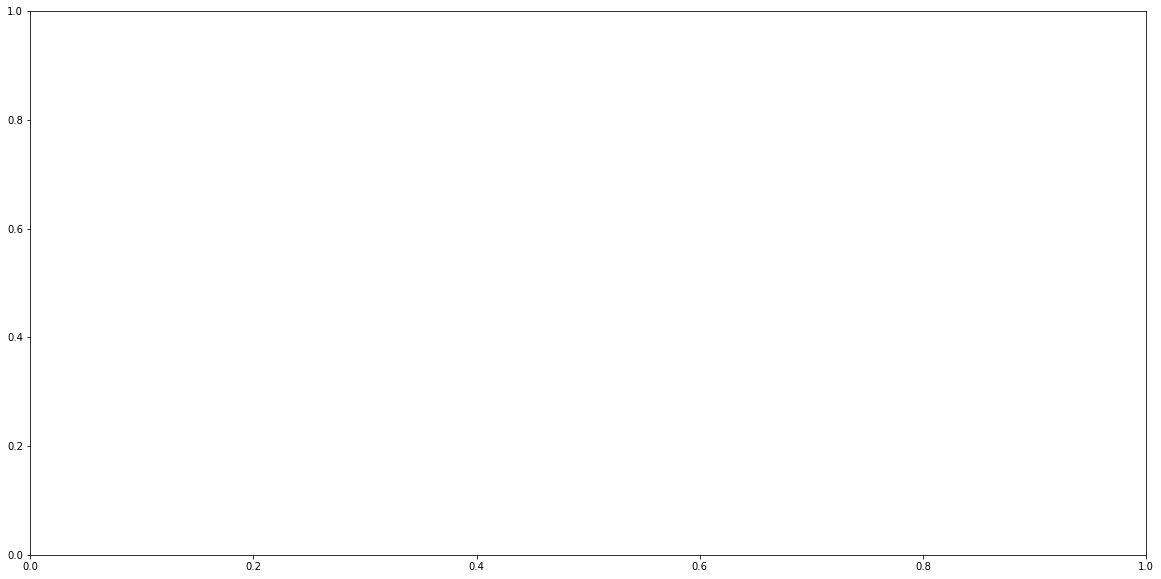

In [120]:
fig, ax = plt.subplots(figsize = (20,10))
sns.boxplot(x="variable", y="value", data=pd.melt(go_terms_jaccard_avg_plotting),color = 'tab:red')
plt.title('For every Go term with more than 10 genes and less than 2000, AVG Jaccard Index between the Go Groups in that species and all other species where the Go Group meets the requirements (N to M)')
plt.xlabel('Species', fontsize = 20)
plt.ylabel('Jaccard Indices',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [ ]:
go_term_summary_with_jaccard = groups_with_values_and_avg_num_genes_in_group.merge(how = 'left',right = jaccard_avg_pd, left_index = True, right_index = True )
go_term_summary_with_jaccard

Avg FC  Avg EGAD  \
GO:0000001       NaN       NaN   
GO:0000002       NaN       NaN   
GO:0000003  0.740324  0.634227   
GO:0000006       NaN       NaN   
GO:0000007       NaN       NaN   
...              ...       ...   
GO:0051184  0.746524  0.598399   
GO:0051194  0.815936  0.739692   
GO:0051182  0.744765  0.607253   
GO:0051185  0.749290  0.614238   
GO:0018065  0.716085  0.771988   

                                                         Name  EGAD Counts  \
GO:0000001                          mitochondrion inheritance            0   
GO:0000002                   mitochondrial genome maintenance            0   
GO:0000003                                       reproduction           10   
GO:0000006  high-affinity zinc transmembrane transporter a...            0   
GO:0000007  low-affinity zinc ion transmembrane transporte...            0   
...                                                       ...          ...   
GO:0051184                                                NaN            5   
GO:0051194                                                NaN            1   
GO:0051182                                                NaN            5   
GO:0051185                                                NaN            5   
GO:0018065                                                NaN            1   

            AVG Family Members Average Genes In Group  AVG Jaccard Index  
GO:0000001                 NaN                    NaN                NaN  
GO:0000002            2.666667                    0-8                NaN  
GO:0000003          620.700000                   500+                NaN  
GO:0000006                 NaN                    NaN                NaN  
GO:0000007                 NaN                    NaN                NaN  
...                        ...                    ...                ...  
GO:0051184                 NaN                    NaN                NaN  
GO:0051194                 NaN                    NaN                NaN  
GO:0051182                 NaN                    NaN                NaN  
GO:0051185                 NaN                    NaN                NaN  
GO:0018065                 NaN                    NaN                NaN  

[44290 rows x 7 columns]

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

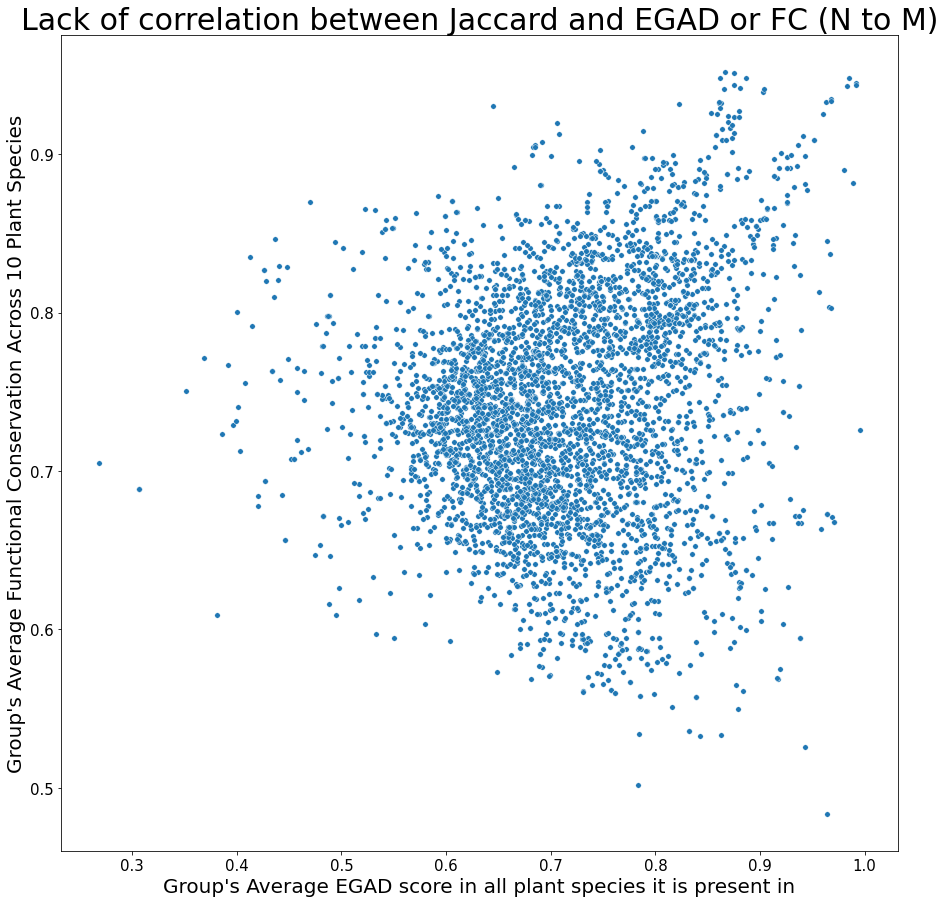

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = go_term_summary_with_jaccard,y = 'Avg FC',x = 'Avg EGAD',s = 30, hue = 'AVG Jaccard Index',palette = 'viridis')
#scatter = ax.scatter(x = groups_with_values_and_avg_num_genes_in_group['Avg FC'],y = groups_with_values_and_avg_num_genes_in_group['Avg EGAD'],c = groups_with_values_and_avg_num_genes_in_group['AVG Family Members'],vmin = 1, vmax = 100)
#handles, labels = scatter.legend_elements(prop = 'colors', alpha = .8,)
#legend2 = ax.legend(handles,labels,loc = 'lower left', title = 'Number of genes in Family')
plt.ylabel("Group's Average Functional Conservation Across 10 Plant Species",fontsize = 20)
plt.xlabel("Group's Average EGAD score in all plant species it is present in", fontsize = 20)
plt.title("Lack of correlation between Jaccard and EGAD or FC (N to M)", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

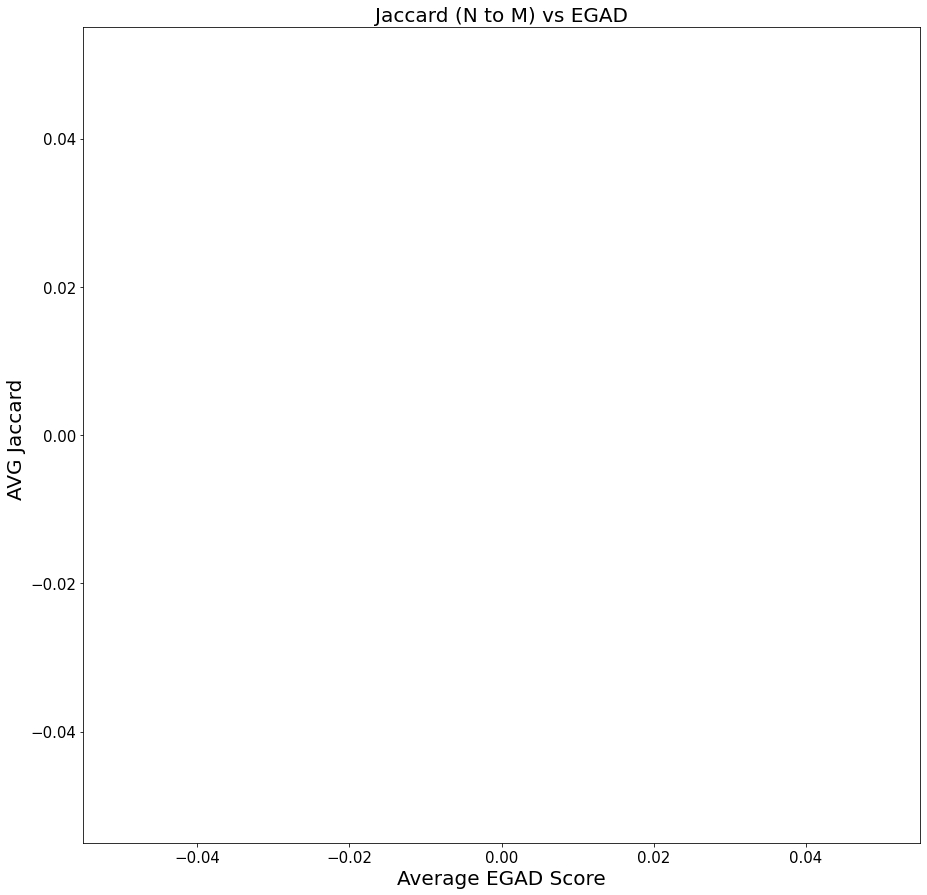

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = go_term_summary_with_jaccard,y = 'AVG Jaccard Index',x = 'Avg EGAD',s = 30, )
#scatter = ax.scatter(x = groups_with_values_and_avg_num_genes_in_group['Avg FC'],y = groups_with_values_and_avg_num_genes_in_group['Avg EGAD'],c = groups_with_values_and_avg_num_genes_in_group['AVG Family Members'],vmin = 1, vmax = 100)
#handles, labels = scatter.legend_elements(prop = 'colors', alpha = .8,)
#legend2 = ax.legend(handles,labels,loc = 'lower left', title = 'Number of genes in Family')
plt.ylabel("AVG Jaccard ", fontsize = 20)
plt.xlabel("Average EGAD Score", fontsize = 20)
plt.title("Jaccard (N to M) vs EGAD", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

(array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

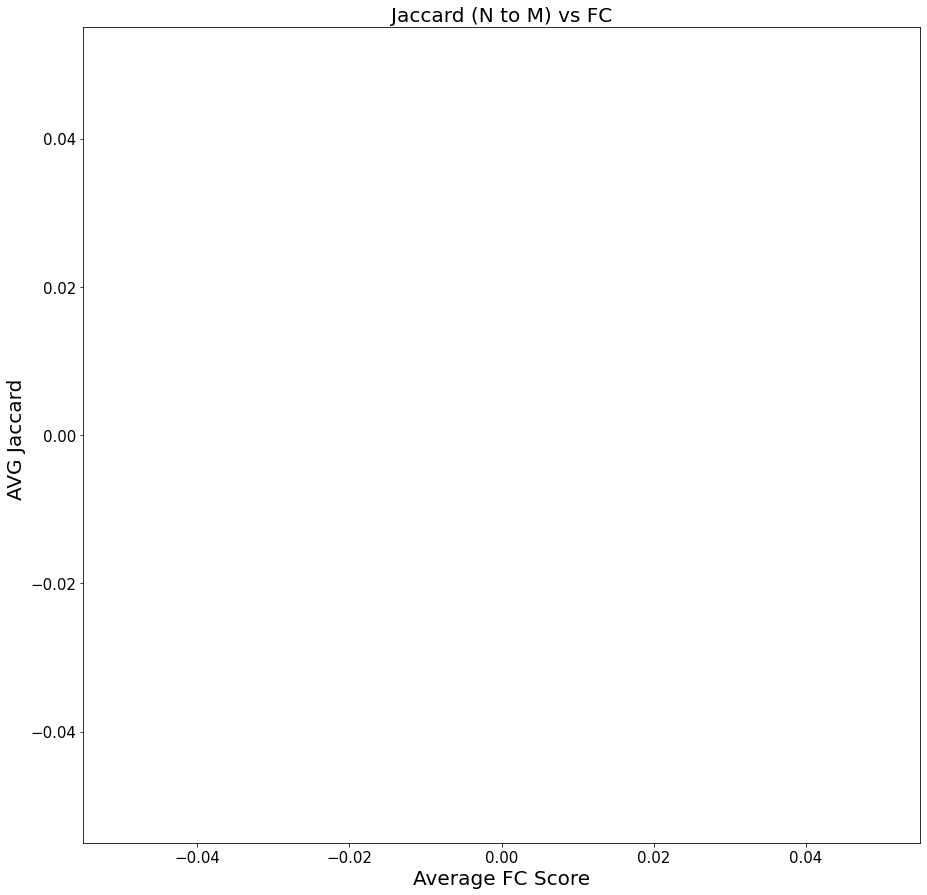

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = go_term_summary_with_jaccard,y = 'AVG Jaccard Index',x = 'Avg FC',s = 30, )
#scatter = ax.scatter(x = groups_with_values_and_avg_num_genes_in_group['Avg FC'],y = groups_with_values_and_avg_num_genes_in_group['Avg EGAD'],c = groups_with_values_and_avg_num_genes_in_group['AVG Family Members'],vmin = 1, vmax = 100)
#handles, labels = scatter.legend_elements(prop = 'colors', alpha = .8,)
#legend2 = ax.legend(handles,labels,loc = 'lower left', title = 'Number of genes in Family')
plt.ylabel("AVG Jaccard ", fontsize = 20)
plt.xlabel("Average FC Score", fontsize = 20)
plt.title("Jaccard (N to M) vs FC", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [ ]:
medicago_groups = get_go_annotations_as_panda('medicago').columns

In [ ]:
len(list(set(go_groups_with_counts.index) & set(medicago_groups)))

7838

In [ ]:
unit = ['grape','arabidopsis']

In [ ]:
filtered_groups_with_values

Avg FC  Avg EGAD                              Name  EGAD Counts
GO:0000003  0.740324  0.634227                      reproduction           10
GO:0000018  0.766573  0.798689   regulation of DNA recombination            8
GO:0000027  0.923946  0.869159  ribosomal large subunit assembly            9
GO:0000028  0.951180  0.875073  ribosomal small subunit assembly            9
GO:0000030  0.714718  0.642678      mannosyltransferase activity            8
...              ...       ...                               ...          ...
GO:0006733  0.724414  0.715443                               NaN            9
GO:0051181  0.732571  0.655892                               NaN            8
GO:0051184  0.746524  0.598399                               NaN            5
GO:0051182  0.744765  0.607253                               NaN            5
GO:0051185  0.749290  0.614238                               NaN            5

[2824 rows x 4 columns]

In [ ]:
variance_all_eudicots['Avg Variance'] = variance_all_eudicots.mean(axis = 1)
variance_all_eudicots


Name     grape  \
GO:0000001                          mitochondrion inheritance       NaN   
GO:0000002                   mitochondrial genome maintenance       NaN   
GO:0000003                                       reproduction  0.001076   
GO:0000006  high-affinity zinc transmembrane transporter a...       NaN   
GO:0000007  low-affinity zinc ion transmembrane transporte...       NaN   
...                                                       ...       ...   
GO:0051184                                                NaN       NaN   
GO:0051194                                                NaN       NaN   
GO:0051182                                                NaN       NaN   
GO:0051185                                                NaN       NaN   
GO:0018065                                                NaN       NaN   

            arabidopsis   soybean  medicago    tomato   potato      rice  \
GO:0000001          NaN       NaN       NaN       NaN      NaN       NaN   
GO:0000002          NaN       NaN       NaN       NaN      NaN       NaN   
GO:0000003     0.000054  0.002042  0.001307  0.003332  0.00249  0.001087   
GO:0000006          NaN       NaN       NaN       NaN      NaN       NaN   
GO:0000007          NaN       NaN       NaN       NaN      NaN       NaN   
...                 ...       ...       ...       ...      ...       ...   
GO:0051184     0.000731  0.000896  0.000870       NaN      NaN  0.002277   
GO:0051194     0.001280       NaN       NaN       NaN      NaN       NaN   
GO:0051182     0.000846  0.000823       NaN       NaN      NaN  0.002400   
GO:0051185     0.000672  0.000823       NaN       NaN      NaN  0.002387   
GO:0018065          NaN  0.002671       NaN       NaN      NaN       NaN   

               brome   sorghum     maize  Avg Variance  
GO:0000001       NaN       NaN       NaN           NaN  
GO:0000002       NaN       NaN       NaN           NaN  
GO:0000003  0.000291  0.000299  0.000990      0.001297  
GO:0000006       NaN       NaN       NaN           NaN  
GO:0000007       NaN       NaN       NaN           NaN  
...              ...       ...       ...           ...  
GO:0051184       NaN  0.001678  0.001048      0.001250  
GO:0051194       NaN       NaN       NaN      0.001280  
GO:0051182       NaN  0.001678  0.001048      0.001359  
GO:0051185       NaN  0.001678  0.001048      0.001322  
GO:0018065       NaN       NaN       NaN      0.002671  

[44290 rows x 12 columns]

In [ ]:
filtered_groups_with_variance = filtered_groups_with_values.merge(right = variance_all_eudicots['Avg Variance'],left_index = True, right_index = True, how = 'left')


In [ ]:
filtered_groups_with_variance

Avg FC  Avg EGAD                              Name  EGAD Counts  \
GO:0000003  0.740324  0.634227                      reproduction           10   
GO:0000018  0.766573  0.798689   regulation of DNA recombination            8   
GO:0000027  0.923946  0.869159  ribosomal large subunit assembly            9   
GO:0000028  0.951180  0.875073  ribosomal small subunit assembly            9   
GO:0000030  0.714718  0.642678      mannosyltransferase activity            8   
...              ...       ...                               ...          ...   
GO:0006733  0.724414  0.715443                               NaN            9   
GO:0051181  0.732571  0.655892                               NaN            8   
GO:0051184  0.746524  0.598399                               NaN            5   
GO:0051182  0.744765  0.607253                               NaN            5   
GO:0051185  0.749290  0.614238                               NaN            5   

            Avg Variance  
GO:0000003      0.001297  
GO:0000018      0.002237  
GO:0000027      0.000240  
GO:0000028      0.000190  
GO:0000030      0.001486  
...                  ...  
GO:0006733      0.001600  
GO:0051181      0.001112  
GO:0051184      0.001250  
GO:0051182      0.001359  
GO:0051185      0.001322  

[2824 rows x 5 columns]

No handles with labels found to put in legend.


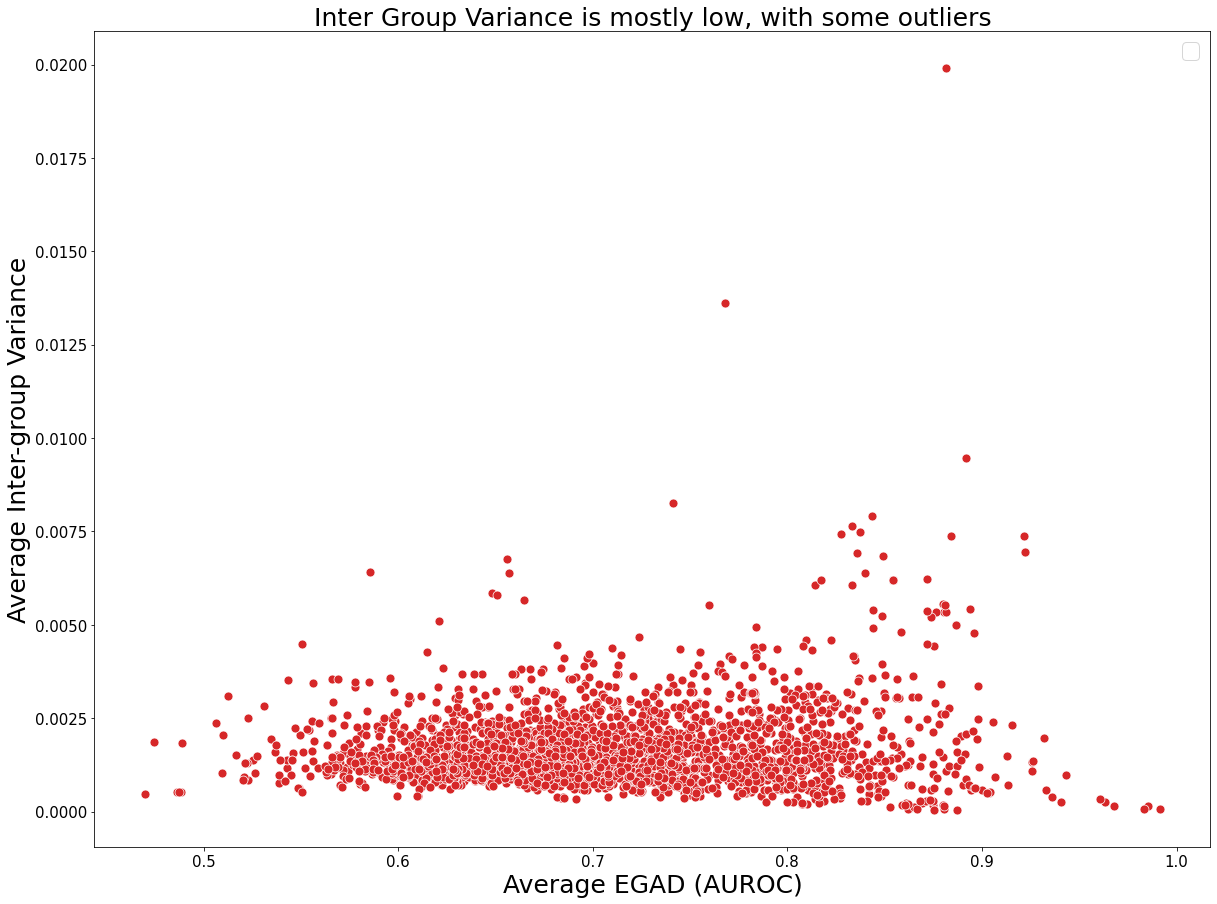

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = filtered_groups_with_variance,y = 'Avg Variance',x = 'Avg EGAD',s = 80,color = 'tab:red')
plt.ylabel("Average Inter-group Variance", fontsize = 25)
plt.xlabel("Average EGAD (AUROC)", fontsize = 25)
plt.title("Inter Group Variance is mostly low, with some outliers", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)